This notebook is heavily inspired by the [pymc3 examples](https://docs.pymc.io/en/v3/nb_examples/index.html) and the fantasitc book **Pattern Recognition And Machine Learning** by Christopher M. Bishop and published by Springer in 2006. It also contains parts of course written with Wandrille Duchemin for the Swiss Institute of BioInformatics 

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import theano
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
import statsmodels


az.rcParams["plot.max_subplots"] = 100

import warnings
warnings.filterwarnings('ignore')

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


# Introducing linear and generalized linear modelling

The problem we are interested in is the following:

We have measured a bunch of variables per individual, for $n$ individuals. 
We are interested in the relationship between one of this variable that we will call the **response variable** 
and the other variables that we will call **covariables**.

Let's illustrate this with the "diabetes" dataset, grabbed from Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf).

It is described as : 
"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."


In [3]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

#this is our response variable
response=pd.DataFrame(diabetes['target'],columns=['disease_progression'])
response.head()

disease_progression
0                151.0
1                 75.0
2                141.0
3                206.0
4                135.0

In [4]:
## this is our covariable
covar=pd.DataFrame(diabetes['data'],columns=diabetes['feature_names'])
covar.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019908 -0.017646  
1 -0.039493 -0.068330 -0.092204  
2 -0.002592  0.002864 -0.025930  
3  0.034309  0.022692 -0.009362  
4 -0.002592 -0.031991 -0.046641


From a mathematical standpoint, we note the response variable vector $\pmb{y}$, and $\pmb{y}_i$ is a single element of that vector (*ie.* the reponse variable measured on a single individual).

Similarly, $\pmb X$ is the matrix of shape $(n,p)$ which contains the values of covariables. 
$\pmb{X}_i$ is a row in this matrix, which corresponds to the measures of the $p$ covariables for individual $i$.

\begin{equation*}
\pmb X = 
\begin{bmatrix}
X_{1,1} & X_{1,2} & ... & X_{1,p} \\
X_{2,1} & X_{2,2} & ... & X_{2,p} \\
 ... \\
X_{n,1} & X_{i,2} & ... & X_{n,p} \\
\end{bmatrix}
 ,\pmb y = 
\begin{bmatrix}
y_{1} \\
y_{2} \\
 ... \\
y_{n} \\
\end{bmatrix}
\end{equation*}

Furthermore, we will consider our response variable to actually be a random variable.
So each $y_i$ is in fact a realisation of a random variable $\pmb Y_i$.

Indeed our measurements are not perfect so there is some noise associated to it ($\epsilon$) : this why we decided to consider our response variable as a random variable. In mathematical term we are interested in a class of problem that we can write as :

$$\pmb{Y}_i=f(\pmb{X}_i)+\epsilon$$

The function $f$ is called the regression function, and today we will be interested in looking at a particular form of those function: **linear combination**.

A particular case of linear combination would be a single covariable with an intercept like :

$$y_i=\beta X_{i,1}+c$$

A more general case would have more covariables and would be written like:

$$f(\textbf{X}_i,\pmb{\beta})=\sum_{j} \beta_j X_{i,j}= \pmb{\beta}^{T}\pmb{X}_{i}$$

Where *$\pmb X_i$* is a vector of $p$ covariables associated to point individual $i$. And $\pmb{\beta}$ is a vector of $p$ coefficients (one for each covariable).

Note that for now nothing is said about the nature of the $X_{i,j}$. For example, some could be constant instead of being a variable (in that specific case they may as well be integrated in the $c$ constant).


In the case of our diabetes example, the response variable is $diseaseprogression$ and the covariables are 
$age , 	sex , bmi , bp, s1 , s2 , s3 , s4 , s5 , s6$.

So in the end, 
we are interested in finding a set of coefficients $\pmb \beta$ so that:

$$disease progression_0=\beta_1 age_0 + \beta_2 sex_0+\beta_3 bmi_0+\beta_4 bp_0+\beta_5 s1_0 +\beta_6 s2_0 + \beta_7 s3_0+\beta_8 s4_0+\beta_9 s5_0+\beta_10 s6_0+\beta_0$$

$$disease progression_1=\beta_1 age_1 + \beta_2 sex_1+\beta_3 bmi_1+\beta_4 bp_1+\beta_5 s1_1 +\beta_6 s2_1 + \beta_7 s3_1+\beta_8 s4_1+\beta_9 s5_1+\beta_10 s6_1+\beta_0$$

$$......$$

$$disease progression_n=\beta_1 age_n + \beta_2 sex_n+\beta_3 bmi_n+\beta_4 bp_n+\beta_5 s1_n+\beta_6 s2_n + \beta_7 s3_n+\beta_8 s4_n+\beta_9 s5_n+\beta_10 s6_n+\beta_0$$

Let's say for now we are only interest in $bmi$ (Body Mass Index) to predict disease progression. 
Then the kind of outcome we want of this analysis is our ability to understand the data linearly like that, which can be summarized by our ability to produce this kind of plots:

slope also called beta in our notation=  949.4352603839499
intercept also called c in our notation=  152.1334841628967


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


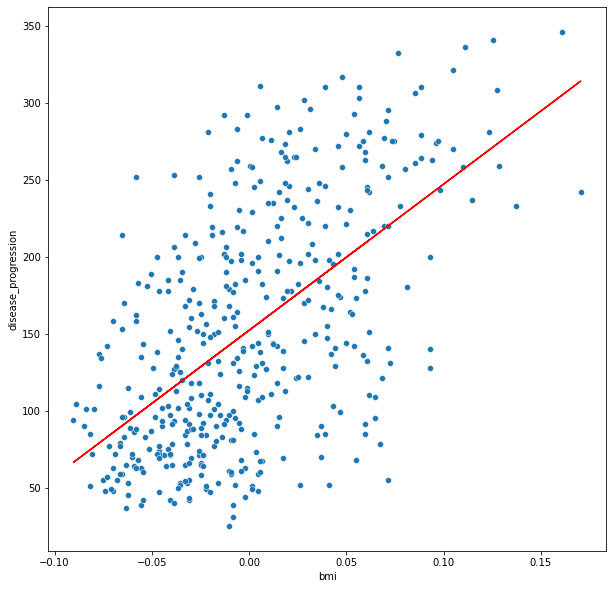

In [5]:
#pulling all the data together in the same dataFrame
df_diabetes = pd.concat( [covar , response] , axis = 1 ) 

x = df_diabetes['bmi'] # covariable bmi
y = df_diabetes['disease_progression'] # response variable disease progression


fig, ax = plt.subplots( figsize = (10,10)) #setup graphical windows
sns.scatterplot(x,y) # plot x versus y

#linear regression explaining disease progression thanks to bmi
slope , intercept , r , pval , stderr = stats.linregress(x,y)
##don't mind how we did the regression for now, this is just for showcasing
print("slope also called beta in our notation= ",slope)
print("intercept also called c in our notation= ",intercept)

#now that we have the outcome iof the regression which is in this case a slope and
#an intercept we can calulate what the model will predict as a disease progression given a bmi value
yPredict = x * slope + intercept 

ax.plot( x , yPredict , color = 'red')#the outcome of the regression is this red line

So of course now the game become to best choose the vector of parameters $\pmb{\beta}$. For that there are two main methods :
- Least Square fit (a method that you are probably well acquointed with, and for which we are not going to spend time on)
- Maximum Likelihood


The way we wrote the function linking $\pmb Y$ to $\pmb X$ above, have the noise term $\epsilon$ outside of the function. So one would say that this function only try to represent the mean of the response variable $\pmb Y$ along the curve. This is what we actually do in the framework of Linear Models : we only aim to fit the mean response thanks to a linear relationship using the covariables. This is straigthforward if $\pmb Y$ is a gaussian random variable as you will see.

If $\pmb Y$ is another random variable, we would linearly fit a transformed mean of the response variable and that's what's called a Generalized linear Model. 

The fitting is done using maximum likelihood. If you consider the $\pmb{\beta}$ as number then you are in a frequentist framework. It is a very useful framework that is very useful most of the time. But to me at least when you start to do things that are a little bit more complicated, like mixed effect models (something needed for our meta analysis), regularized models gaussian processes etc... the frequenctist famework is a bit more obscur.
Instead, the bayesian framework which considers the $\pmb{\beta}$ as being random variables, makes more sense.

In the following I will try to give you both sides of the coin using statsmodel which is frequentist and pymc which is a probabilistic framework. 

## Maximum Likelihood <a id='0'></a>

Maximum Likelihood is a method that is used to estimate parameters of a probablililty distribution. It is done by **maximizing the likelihood function**. In the case that we are interested in (i.e. independant identically distributed) this likelihood function is simply the product of  a density function values over the entire sample. **It is a parametric method** since it needs to have an a priori about the density function for it to work. 

Since it is a product, most of the time we would rather work with the log likelihood function which transforms this product into a sum.

So we would like to maximize $l$, the loglikelihood function, by choosing a set of parameters $\pmb\beta$.
Where $l$ is of the form:

$$l(\pmb\beta;X)=\sum_i ln(p(x_i|\pmb\beta))$$

Where $X$ is a random variable and $p()$ is the density function associated to $X$. So you want to find the following estimation for $\pmb\beta$

$$\hat{\pmb\beta}=\text{arg max}_{\pmb\beta}l(\pmb\beta;X)$$

> Note : this formulation of the likelihood relies on the Bayes theorem. It puts forward that the likelihood of parameters given the observed data depends on the probability of the observed data given the parameters. Thus, in ML we search the parameters for which the observed data seems the most probable.


Let's take the example of a gaussian where you would like to estimate the $\sigma$ and the $\mu$, given your data. As they are simulated data we chose that $\mu=2$ and $\sigma=0.5$

In [6]:
def gaussian_dist(x,mu,sigma):
    """ returns the probability of observing x in a normal distribution of mean mu and standard deviation sigma """
    return 1./(sigma*np.sqrt(2*np.pi))*np.exp(-1./(2*sigma**2)*(x-mu)**2)
    # note : this is equivalent to stats.norm.pdf( x , mu , sigma )

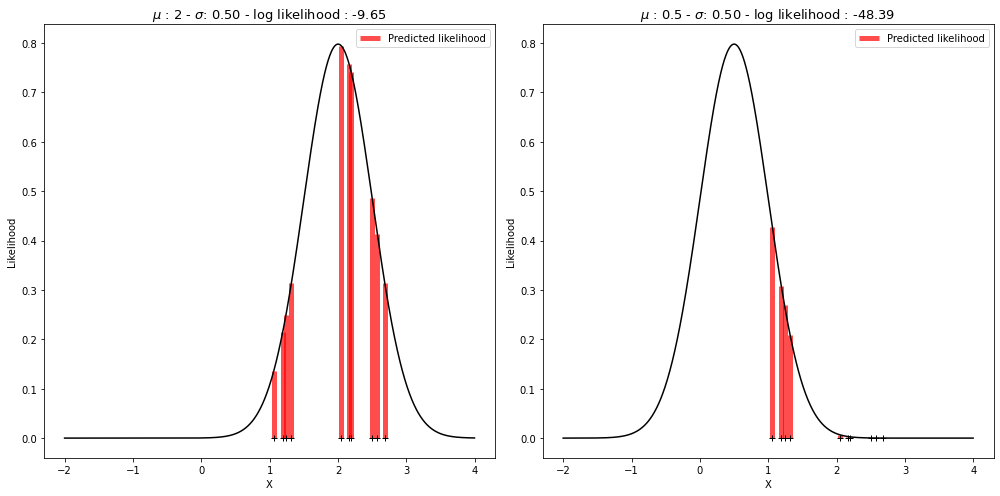

In [8]:
from matplotlib import collections  as mc
X_small=np.random.randn(10)*0.5+2 # this is our observed data, with ( mean=2 , sd=0.5 )

m=[2,0.5] # we will try 2 possible combinations of paramters ( mean=2 , sd=0.5 ) and ( mean=0.5 , sd=0.5 ) 
s=[0.5,0.5]


fig, ax = plt.subplots(ncols=len(m) , figsize = (14,7))
X_small_=[[v,0] for v in X_small]

x=np.arange(-2,4,0.005) # we will plot between -2 and 4

for q in range(len(m)): # for each of the parameter combinations we want to try
    ax[q].plot(X_small,[0]*len(X_small),'k+') # we plot the observed data as crosses

    ax[q].plot( x , stats.norm.pdf( x , loc = m[q] , scale = s[q] ),'k') # we plot the distribution we are testing
    
    Predicted = stats.norm.pdf( X_small , loc = m[q] , scale = s[q] )

    Predicted_= [i for i in zip(X_small,Predicted)] # this is to plot segments
    lc = mc.LineCollection(zip(X_small_,Predicted_) , colors='red',linewidths=5,alpha=0.7,label='Predicted likelihood')
    ax[q].add_collection(lc)
    ax[q].legend(loc='best',fontsize=10)
    
    # the log likelihood of this set of parameters is the sum of the log of the probability densities of the sample
    sum_like=sum(np.log(Predicted))     
    ax[q].set_title('$\mu$ : {} - $\sigma$: {:.2f} - log likelihood : {:.2f}'.format(m[q],s[q],sum_like) ,fontsize=13)
    
    ax[q].set_xlabel('X')
    ax[q].set_ylabel('Likelihood')


plt.tight_layout()    

Multiplying those red bars is exactly what the maximum likelihood does. 

Basically, you shift your theoritical distribution to the right or the left (trying different means), and you narrow it or widen it (trying different variances). 

For each of those try you multiply those red bars together, and the combination of parameters giving highest result is the one maximizing the likelihood of your data being produced by that distribution with those parameters.


It is important to point out here that **even when our data are actually coming from a certain distribution, there will (almost) always be a difference between the theoretical distribution and the recovered one**, as to have perfect match you would need an infinite number of data points.


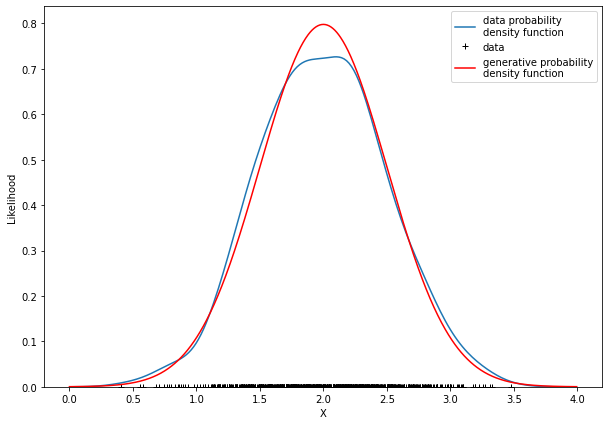

In [9]:
X=np.random.randn(800)*0.5+2
fig = plt.figure(figsize = (10,7)) 
sns.kdeplot(X,label='data probability\ndensity function')
x=np.arange(0,4,0.005)
plt.plot(X,[0]*len(X) ,'k+',label='data')
plt.plot(x, stats.norm.pdf( x , loc = 2 , scale = 0.5 ) ,'r',label='generative probability\ndensity function')
plt.ylabel('Likelihood')
plt.xlabel('X')
plt.legend(loc='best',fontsize=10)

Let's test many combinations of possible means and standard deviations to see where our maximum of likelihood lies.

Highest likelihood is for \mu and \sigma : 2.0 0.5


<ipython-input-10-5cc52719cb02>:30: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


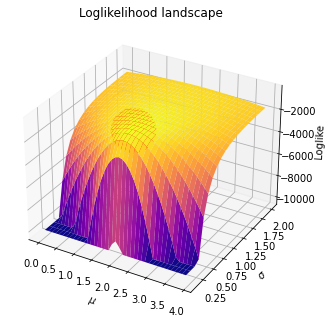

In [10]:
import math

mu=np.arange(0,4,0.1) # from 0 to 4 by increments of 0.1
sigma=np.arange(0.1,2.1,0.1) # from 0.1 to 2.1 by increments of 0.1

mu,sigma=np.meshgrid(mu,sigma) # this useful function combines all possibles values for mu and sigma
def loglike_func(X,mu,sigma):
    """returns a list of the loglikelihoods of mus and sigmas given data X"""
    ll = []
    for i in range(len(mu)):
        ll.append( sum(np.log(stats.norm.pdf(X,mu[i],sigma[i]))) )
        if math.isnan(ll[-1]) or ll[-1] < -10000: 
            ll[-1] = -10000 # we verify that no numerical error gave us an NaN or very small log value
    return ll

# we compute the log-likelihood for all tested parameters values 
zs=np.array(
    loglike_func(X,np.ravel(mu),np.ravel(sigma))
) 
loglike=zs.reshape(mu.shape)

bestMu = np.ravel(mu)[np.argmax(zs)]
bestSigma = np.ravel(sigma)[np.argmax(zs)]

# make a 3D figure of our loglikelihood landscape
from mpl_toolkits.mplot3d import Axes3D 
print(r'Highest likelihood is for \mu and \sigma :',bestMu,bestSigma)

fig = plt.figure() 
ax = Axes3D(fig)
ax.plot_surface(mu,sigma,loglike,cmap='plasma') 
ax.scatter(bestMu,bestSigma,max(zs),s=2000,c='r') # put a dot at the ML value
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Loglike')
plt.title("Loglikelihood landscape")

plt.show()

Nicely enought this maximum likelihood method allows us to recover the true parameters of the distribution.


Let us look at the curvature of the loglikelihood space as it is bearing useful information. For that we are going to look at how the log likelihood function behave in function of $\mu$ when $\sigma=0.5$. Same for the behaviour of the likelihood function according to $\sigma$ when $\mu=2$

In [11]:
def loglike_func_1Param(X,mu=2,sigma=0.5):
    ll=sum(np.log(stats.norm.pdf(X,mu,sigma)))    
    if math.isnan(ll)==True or ll<-10000:
        ll=-10000
    return ll

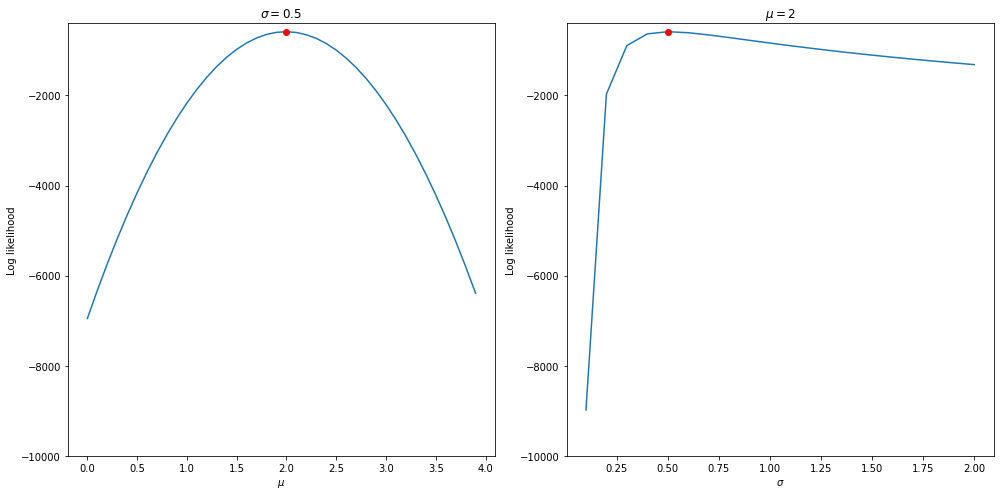

In [12]:
fig, ax = plt.subplots(ncols=len(m) , figsize = (14,7))
mu=np.arange(0,4,0.1)
sigma=np.arange(0.1,2.1,0.1)

for q in range(2): 
    if q==0: # different values of mu for sigma=0.5
        ax[q].plot(mu,[loglike_func_1Param(X,mu=v,sigma=0.5) for v in mu])
        ax[q].plot([2],[loglike_func_1Param(X,mu=2,sigma=0.5)],'ro')
        ax[q].set_xlabel('$\mu$')
        ax[q].set_ylabel('Log likelihood')
        ax[q].set_title('$\sigma=0.5$')
    if q==1: # different values of sigma for mu=2
        ax[q].plot(sigma,[loglike_func_1Param(X,sigma=v,mu=2) for v in sigma])
        ax[q].plot([0.5],[loglike_func_1Param(X,sigma=0.5,mu=2)],'ro')
        ax[q].set_xlabel('$\sigma$')
        ax[q].set_ylabel('Log likelihood')
        ax[q].set_title('$\mu=2$')
    ax[q].set_ylim([-10000,-400])
plt.tight_layout()

I would to draw a little bit of attention on the curvature of the loglikelihood function here. You can see here that the way the loglikelihood drops around the red dot is quite different for $\mu$ and $\sigma$. For $\mu$ the steepness of the slopes around the maximum are important an well defined, whereas for $\sigma$ it is way flatter. This has a direct consequence on how narrow your confidence interval around the estimated parameters are going to be. 

You can see that as the log likelihood function is flatter, there is a wider range of $\sigma$ that have a loglikelihood equivalent to the maximum.

I was talking about the "steepness of the slopes" before. In mathematical terms this corresponds to the second derivative of the loglikelihood function. The bigger this second derivative is the steeper are the slopes. You can put all those second derivatives in a matrix called the hessian matrix. In our case : 
$$
\begin{bmatrix}
    \frac{\partial^2l}{\partial\mu^2} & \frac{\partial^2l}{\partial\mu\partial\sigma} \\
    \frac{\partial^2l}{\partial\sigma\partial\mu} & \frac{\partial^2l}{\partial\sigma^2}
  \end{bmatrix}
$$

You can have a geometrical intepretation of the confidence interval by seeing that it is related to the inverse of this second derivative or the inverse of that hessian matrix. This inverse is called radius of curvature, and the bigger the second derivative is going to be, the smaller that radius of curvature is going to be. 

In other words, when the highest value really pops up from the ones around it in the likelihood landscape, then the confidence interval around the best values of the parameters is small.

## Let's do a regression where Y is normally distributed 

Let's now imagine that we try to fit the average of a Y, $\hat{Y}$, along the curve $\hat{Y}=\beta X+c$ for which the noise around those averages is gaussian. 

Since we didn't put the noise in this equality, it really represents a fit of the average of Y with some gaussian noise around it. The equation representing the fitting of Y would be $Y=\beta X+c+\epsilon$. 

We could thus consider that we can switch to the following problem of distribution fitting, defined by the density function of a normal law:

$$p(y_i|\bar{y_i},\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}*\exp(-\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2})$$

Note that the parameters you want to estimate are $\bar{y_i}$ and $\sigma$ (note that $\bar{y_i}$ serves as the mean of the normal distribution here).

By definition of the  likelihood function over $n$ individuals in a sample is:

$$\Pi_i \frac{1}{\sqrt{2\pi\sigma^2}}*\exp(-\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2})$$

which transformed into the loglikelihood function:

$$l(\bar{y_i},\sigma;Y) = \sum_i -\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2} + constant = -\frac{1}{2 \sigma^2} \sum_i (y_i-\bar{y_i})^2 + constant$$

And we try to find the maximum of this expression.

Now, in the frame of a linear model, we have $$\bar{y_i}=\beta x_i+c$$

And in least square, we try to find the minimum of :
$$\sum_i (y_i- \beta x_i+c )^2 = \sum_i (y_i-\bar{y_i})^2 $$




You see now that maximizing $\sum_i -(y_i-\bar{y_i})^2$ over $\beta$ (Maximum Likelihood) is the same as minimizing $\sum_i (y_i-\bar{y_i})^2$ over $\beta$ (Oridnary Least Square).

#### if you want to dig deeper : What about the confidence interval ? 

As a side note for now, but important for the rest:

$$\hat{\pmb\beta}=(\pmb X^T \pmb X)^{-1}\pmb X^T \pmb Y$$

is the solution from both the maximum likelihood in the case of normally distributed noise, and the least square fit.

As a quick proof, and also to get a feeling of how all of this is working we can take the simple case of $\bar{y_i}=\beta x_i=f(x_i,\beta)$.

In that case the loglikelihood look like 

$$l=\sum_i -\frac{1}{2}\frac{(y_i-\beta x_i)^2}{\sigma^2} + constant $$

$$\frac{\partial l}{\partial \beta}\propto\sum_i -2x_iy_i + 2\beta x_i^2$$

You want $\frac{\partial l}{\partial \beta}(\hat{\beta})=0$ as you are maximizing the likelihood so you end up with:

$$\hat{\beta} \sum_i x_i^2=\sum_i x_iy_i$$

Which in multivariate actually corresponds to $(\pmb X^T \pmb X)\hat{\pmb\beta}=\pmb X^T \pmb Y$

The term $(\pmb X^T \pmb X)$ plays a special role: 

$(\pmb X^T \pmb X)$ is generally related to the covariance of $\pmb X$. But in that specific case (normality), it is also a matrix representing the curvature of the log likelihood function at $\hat{\pmb \beta}$. You calculate the curvature of a function by calculating the matrix of second derivative called hessian. In our case you just differentiate one more time what we found before :

$$\frac{\partial^2 l}{\partial \beta^2}\propto\sum x_i^2$$

And indeed you find this $\sum x_i^2$ term which in multivariate forms is $(\pmb X^T \pmb X)$.

Calculating a confidence interval in the general case (in the case of the GLM that we will see later for example), involves inverting the curvature of the loglikelihood function at the estimated $\hat{\pmb \beta}$ and put in a normal confidence interval as seen before. 
In statistic this curvature matrix (also called hessian in mathematic) is related to the Fisher Information.

From our intuition derived before we can write $\beta_j \in [\hat{\beta_j} \pm z_{1-\frac{\alpha}{2}}\sqrt{\hat{\sigma}^2 [(\pmb X^T \pmb X)^{-1}]_{j,j}}]$

Those confidence intervals are made thanks to a $z_{1-\frac{\alpha}{2}}$ meaning that $\hat{\beta_j}$ is believe to be gaussian distributed if given enough fitting points. This is not straightforward to prove here (as the log likelihood is a sum you can bet that Central Limit Theorem is at play somewhere here), but is is a feature of maximum likelihood. The thing is that here you are calculating those confidence interval just like your estimator was actually representing the average of a distribution of possible estimator values : but we never talk about estimator $\beta_j$ being a radom variable....Moreover if that was the case we never really defined how those $\beta_0,\beta_1,...,\beta_j,...,\beta_n$ where constrained by each others (covariance for example).

Looking at those estimators as random variables from the get go is what Maximum A Posteriori (MAP) is doing, and to a larger extent what Bayesian methods do. We are going to talk a lot more about Bayesian modeling in the following but first let's see how to deal with random target random variables $y_i$ is not normally distributed.  

## Generalized linear models

If you remember, to use our Maximum Likelihood Estimator method, we spent a lot of time before saying that we were looking to solve a very specific kind of problem : one where we wanted to fit the mean of $\pmb Y_i$ knowing some value $\pmb X_i$ , and that there was some gaussian noise $\mathcal{N}(0,\sigma^2)$ around the mean of $\pmb Y_i$.

In mathematical term we were modeling our problem with the following distribution:

$$P(\pmb Y_i|\pmb X_i)=\mathcal{N}(\pmb{\beta}^{T}\pmb{X}_{i},\sigma^2)$$

On which we were using Maximum Likelihood Estimation 

Thus so far, we have restricted ourselves to purely straightforward linear relations between the mean of $\pmb Y_i$ conditional to $\pmb X_i$ i.e.:

$$\mu(\pmb X_i)=\mathbb{E}(\pmb Y_i|\pmb X_i)=(\pmb{\beta}^{T}\pmb{X}_{i})$$


We have also only looked at case where the noise was normaly distributed : hence the $\mathcal{N}$ above. 

Under some conditions (i.e your random component is part of the exponential distribution family) you can relax those conditions.

Remember, as we want to use linear models the only thing we can not change is our fitting using $\pmb{\beta}^{T}\pmb{X}_{i}$. But this linear relationship doesn't have to apply to the conditional mean $\mu(\pmb X_i)$ but instead to a function of that conditional mean:

$$g(\mu(\pmb X_i))=\pmb{\beta}^{T}\pmb{X}_{i}$$

**$g$ is called the link function**, and we will investigate a little bit more what it can be and why it is useful. 


Another possibility is that rather than a normal distribution we could also look for a more general distribution to model the noise induced by the interaction between our $\pmb Y_i$ and $\pmb X_i$:

$$P(\pmb Y_i|\pmb X_i)=\mathcal{D}(g^{-1}(\pmb{\beta}^{T}\pmb{X}_{i}),\sigma^2)$$

Where $\mathcal{D}$ is a distribution that makes sense to model our $\pmb Y$ random variable, and $g^{-1}$ the inverse of the link function.

And on top of that we could still work with our Maximum Likelihood Estimator method/ bayesian estimation framework.

Thanksfully python libraries allow us to do all of that and more in a really easy way.

## Baye's formula and underlying concepts

Let's go back to to our Maximum likelihood estimation : 

$$\pmb\beta_{MLE} = argmax_{\pmb\beta}\text{ } \sum_i ln(P( y_i \mid \pmb\beta, \pmb X_i))$$

You can read that as : the $\pmb\beta$ that we are interested in, also know as $\pmb\beta_{MLE}$, is the one that maximise the likelihood of having produce the data $\pmb Y$.

So it seems that there were plenty of $\pmb\beta$ available in the wild, but we decided that we were interested in a very particular one, ignoring somehow what the diversity/distribution of $\pmb\beta$ was.

Since we are looking at the likelihood of the data, and by how we decided to treat the target $\pmb Y$, it is obvious that $\pmb Y$ is a random variable. That being said right now we have access to a singular realization of $\pmb Y$, but plenty other realization of the dataset $\pmb Y$ exist somewhere. Maybe we had access only to a subsample of the data, maybe later on we remeasure $\pmb Y$ for some other values of $\pmb X$.

So it seems a little harsh to choose our $\pmb\beta$ without taking into account that it is a random variable and only by looking at one dataset when we know that those dataset are also distributed.

So instead of looking at the likelihood that the $\pmb\beta$ produces the data $\pmb Y$, let's look at the probability that the data produces those $\pmb\beta$ : 

$$P(\pmb\beta\mid\pmb X,\pmb Y)=\Pi_i P(\pmb\beta\mid\pmb X_i,y_i),{\pmb Y}_i \text{ are i.i.d.}$$

This last formula is called the posterior

If we were looking at the $\pmb\beta$ that were the most probable (the mode) given the data :

$$\pmb\beta_{MAP} = argmax_{\pmb\beta}\text{ } P(\pmb\beta\mid\pmb X,\pmb Y)$$

We would be doing Maximum A Priori (MAP) estimation. Its link to MLE is obvious if we use Baye's Theorem :


$$p(A\mid B) = \frac{p(B\mid A) p(A)}{p(B)} \propto p(B\mid A) p(A)$$

In our case this translate to 

$$p(\pmb\beta\mid \pmb Y,\pmb X) = \frac{p(\pmb Y\mid \pmb\beta,\pmb X) p(\pmb\beta)}{p(\pmb Y\mid \pmb X)} $$


You recognize the likelihood of generating such data given $\pmb\beta,\pmb X$ $p(\pmb Y\mid \pmb\beta,\pmb X)$, $p(\pmb\beta)$ is called the prior (distribution of our parameters) and represent our a priori understanding of the world (before collecting data), and $p(\pmb Y\mid \pmb X)$ is the probability of finding such data. This last part is most of the time unknown and hard to compute and will necessitate intervention of particular techniques. The prior itself is a guess but its choice has some interesting consequences.

Now if we are interested in the $\pmb\beta_{MAP}$ :

$$\pmb\beta_{MAP} = argmax_{\pmb\beta}\text{ } \frac{p(\pmb Y\mid \pmb\beta,\pmb X) p(\pmb\beta)}{p(\pmb Y\mid \pmb X)} $$

Since $p(\pmb Y\mid \pmb X)$ doesn't depend on $\pmb\beta$ :


$$\pmb\beta_{MAP} = argmax_{\pmb\beta}\text{ } p(\pmb Y\mid \pmb\beta,\pmb X) p(\pmb\beta)$$

And let's imagine $p(\pmb\beta)\sim \mathcal N(0,\lambda² \pmb I_p)$ which means that we believe that 95% of the possible betas should be between $0\pm1.96*\lambda$

$$\pmb\beta_{MAP} = argmax_{\pmb\beta}\text{ } p(\pmb Y\mid \pmb\beta,\pmb X) p(\pmb\beta)$$
<br>
<br>
$$\pmb\beta_{MAP} = argmax_{\pmb\beta} \text{ } ln(p(\pmb Y\mid \pmb\beta,\pmb X)) +ln(p(\pmb\beta))$$
<br>
<br>
$$\pmb\beta_{MAP} = argmax_{\pmb\beta} \text{ } l(\pmb\beta,\pmb X) -\frac{1}{2\lambda²}*\pmb\beta^{T}\pmb\beta $$
<br>
<br>
$$\pmb\beta_{MAP} = argmax_{\pmb\beta} \text{ } \sum_i l(\pmb\beta,\pmb X_i) -\frac{1}{2\lambda²}*\sum_p\pmb\beta^{2}$$

if $y_i\sim \mathcal N(\pmb\beta^{T}\pmb X_i,\sigma² \pmb I_n)$

$$\pmb\beta_{MAP} = argmax_{\pmb\beta} \text{ }-\frac{1}{2\sigma²}*\sum_i (y_i-\pmb\beta^{T}\pmb X_i)² -\frac{1}{2\lambda²}*\sum_p\pmb\beta^{2}$$

So you recognize that this is almost the MLE but with a term called regularization which stop the $\pmb\beta_{MAP}$ from being unnecessarily big.

If we would have guess that $p(\pmb\beta)\sim Uniform(a,b)$ then the term in the MAP would be a constant (since the probability of $\pmb\beta$ doesn't depend on $\pmb\beta$) and could be ignored, hence MAP is MLE if you choose a uniform prior.

A prior is really your understanding of the world : by choosing a prior you choose the degree of knowledge you think you have. Indeed by choosing a prior you choose for example a mean and even more importantly a standard deviation for those  $p(\pmb\beta)$ to be drawn from.


If we don't take the argmax but generate many  $\pmb\beta$ according to 
$$p(\pmb\beta\mid \pmb Y,\pmb X)$$

and this is not an easy thing to do (namely Monte Carlo methods), then we do Bayesian's modelling : we will be able to ahve true error bars on the targets ($\pmb Y$) and the parameters $\pmb\beta$.

Let's look at what that means






## A first dip in the bayesian modeling framework

In [324]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
size = 200
true_intercept = 3
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=1, size=size)

data = pd.DataFrame(dict(x=x, y=y,intercept_x=np.ones((len(x))))).sample(frac=1)
data

x         y  intercept_x
29   0.145729  3.722278          1.0
175  0.879397  4.931382          1.0
199  1.000000  4.836557          1.0
66   0.331658  3.314592          1.0
156  0.783920  4.698114          1.0
..        ...       ...          ...
9    0.045226  2.237408          1.0
131  0.658291  2.939897          1.0
72   0.361809  2.804166          1.0
142  0.713568  2.295089          1.0
20   0.100503  3.016143          1.0

[200 rows x 3 columns]

So let's say our data look like that (see below). FYI those data are just a 
$$y_i=3+2*x_i +\epsilon$$
where epsilon is a gaussian noise with scale =1 i.e. 
$$\epsilon\sim\mathcal{N}(0,1)$$
Thus in our framework the true regression ligne (the one generated without the noise, or similarly with the noise averaged out) is $$\bar y_i=3+2*x_i$$



We don't know about those coeffcients but looking at this plot it seems than expecting a simple linear relation to x is not too much of guess. Same with the fact that both the slope and the intercept have a great chance to be positive

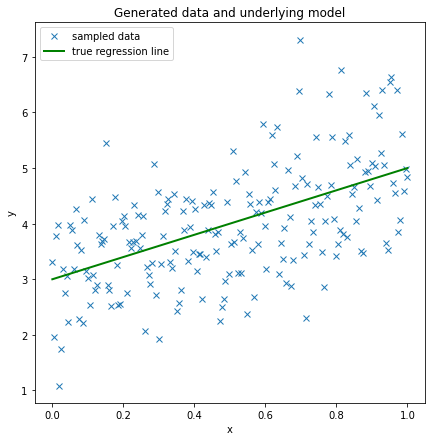

In [325]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line,'green', label="true regression line", lw=2.0)
plt.legend(loc=0);

Below let's prepare our data. We are looking for two coefficients in our model, the slope and the intercept. As we are looking for models of the type $\pmb y = \pmb\beta X^{T}+\epsilon$, our $X$ needs to have also two components : one that influences the slope and one that influences the intercept. This is why our $X$ is going to be $[[1,x_i]]_{i =1,.., N}$

In [326]:
X=np.array(data[['intercept_x','x']])
y=np.array(data['y'])

As commented earlier with an appriori already about some properties of our $\beta_j$ : they are probably only 2 (a slope and an intercept) and they are probably bigger than 0.

Let's encode that in our prior :
Our prior is going to be a bivariate normale distribution centered around 1 for both $\beta_j$ and with an identity matrix as covariance matrix. This means that the scale for both $\beta_j$ is going to be one, and that we believe that they live without interactions (no diagonal part on the covariance matrix) : choosing one doesn't influence the other one -> this is a weird assumption but we will see that bayesian modelling take care of that.

In [ ]:
def prior_distri(N,m_0,S_0):
    return np.random.multivariate_normal(m_0, S_0, N)

def prior_matrix(mean,covariance,betas):
    mat = np.zeros((len(betas[1]),len(betas[0])))
    d=2
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            x_m = np.array([betas[0][j],betas[1][i]]) - mean
            mat[i][j] = (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
    return mat

Let's look at what that prior look like by plotting it on a range of slopes and intercept , here called `betas_tries`.

In [ ]:
betas_tries = np.array([np.arange(-4, 5, 0.01),
                         np.arange(5, -4, -0.01)])

In [ ]:
true_slope_matrix=np.argmin((np.arange(5, -4, -0.01)-true_slope)**2)
true_intercept_matrix=np.argmin((np.arange(-4, 5, 0.01)-true_intercept)**2)

In [ ]:
mat_prior=prior_matrix(np.ones(2),np.eye(2),betas_tries)

We can see that the prior is indeed centered on (1,1), with most of its density within a distance of one from its center. Moreover the prior as a circular symmetry which is caused by the fact there is no out of diagonal terms in the covariance matrix.

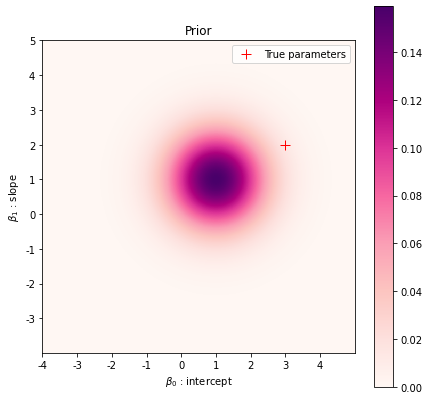

In [208]:
plt.figure(figsize=(7, 7))
plt.imshow(mat_prior,interpolation='nearest',cmap='RdPu')
plt.plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
plt.xticks(np.arange(0,betas_tries[1].shape[0],100),np.arange(-4, 5, 1))
plt.yticks(np.arange(0,betas_tries[1].shape[0],100),np.arange(5, -4, -1))

plt.legend(loc='best')
plt.xlabel(r'$\beta_0$ : intercept')
plt.title('Prior')
plt.ylabel(r'$\beta_1$ : slope')
plt.colorbar()
plt.show()

The game here again is to recover the form of our posterior 
$$p(\pmb\beta\mid \pmb Y,\pmb X)$$


This gives us a way to calculate the probability for our x and y but doesn't give us a way to draw from that distribution because we don't know what this distribution is  : is it a gaussian?  is it a poisson? etc... Having a way to calculate the probablity for certain points doesn't translate to knowing the distribution and be able to draw from it . And knowing the distribution is exactly what we want : because we would like to have better confidence intervals for our $\pmb\beta$ but also confidence interval for our prediction on y , which is something that only Bayesian modeling can give us. 

In reality having access to a good approximation of the posterior distrbution that will allow us to draw from it , is hard and involves Monte Carlo methods. You can imagine tha this is hard for two linked main reasons :

- The posterior right now have a denominator that is unknown but that you could still write as a sum (an integral), that makes sure that the output of your posterior are indeed a probability (between 0 and 1):
$$p(\pmb Y \mid \pmb X)=\int p(\pmb Y \mid \pmb X,\pmb \beta) d\pmb\beta$$
- The posterior and its denominator are multidimensional, even in our very simple problem the dimension is 2: you look at the intercept $\beta_0$ and the slope $\beta_1$ -> $\pmb\beta=[\beta_0,\beta_1]$. Sou might be looking at solving at a multidimensional integral for the denominator, but also at the numerator... Indeed you might prefer to solve for your posterior one parameter at a time. For example to get the posterior for $\beta_0$ you will have to solve :
$$p(\beta_0\mid\beta, \pmb X, \pmb Y)=\int p(\beta_0,\beta_1\mid, \pmb X, \pmb Y)p(\beta_1)d\beta_1$$
$$p(\beta_0\mid\beta, \pmb X, \pmb Y)=\int p(\pmb\beta\mid, \pmb X, \pmb Y)\frac{p(\pmb\beta)}{p(\beta_0\mid\beta_1)}d\beta_1$$

In general, if you end up with a hard integral to solve, Monte Carlo techniques are your friends.

Luckily the fact that both the likelihood and the prior here are Normal like, allows us to have analytical solution for the posterior. This is what the code below do : write the analytical solution of the posterior.


The library we are going to use for Bayseian modelling allows us to use Monte Carlo under the hood and so be more general than what we are presenting here for pedagological reasons.**I am not sure I want to have a dedicated part on MC methods...**


TLDR : you don't need to understand the next cell.

In [226]:
def m_n(S_n,S_0,m_0,X,y,epsilon):
    return S_n@(np.linalg.inv(S_0)@m_0+epsilon*X.T@y)

def S_n(epsilon,S_0,X):
    return np.linalg.inv(np.linalg.inv(S_0)+epsilon*X.T@X)

def p_beta_given_y_distri(N,m_n,S_n):
    return np.random.multivariate_normal(m_n, S_n, N)

def p_beta_given_y(N,X,y,S_0,m_0,betas,epsilon):
    mat = np.ones((len(betas[1]),len(betas[0])))
    d=2
    covariance=S_n(epsilon,S_0,X[:N,:])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            x_m=np.array([betas[0][j],betas[1][i]])-m_n(covariance,S_0,m_0,X[:N,:],y[:N],epsilon)
            mat[i][j] = (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
    return mat

def likelihood(X,y,N,sigma,betas):
    mat = np.ones((len(betas[1]),len(betas[0])))
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            x_m=y[:N]-np.array([betas[0][j],betas[1][i]])@X[:N,:].T
            mat[i][j] =1./(sigma*np.sqrt(2*np.pi))**(N)*np.exp(-1./(2*sigma**2)*(np.sum(x_m**2)))
    return mat

def make_linear_fn(x,betas):
    return betas@x.T

The message I would like to convey now is that the posterior can be seen as un updated prior. What's updating it is the data, through the likelihood. Also the prior constrains the posterior for low number of data points but with more and more data points the likelihood have a tendancy to take over yet still constrained by the prior (for example it can narrow or widen the acceptable range of $\pmb\beta$ that you will have with only maximum likelihood).

Finally now that we have a posterior we are going to draw from it to have different prediction for our modelled y, and so see what is the uncertainty around those modelled y.

In [227]:
mat_likelihood_1=likelihood(X,y,1,np.array([1]),betas_tries)
p_beta_given_y_1=p_beta_given_y(1,X,y,np.eye(2),np.ones(2),betas_tries,1)
covariance_1=S_n(1,np.eye(2),X[:1,:])
mn_1=m_n(covariance_1,np.eye(2),np.ones(2),X[:1,:],y[:1],1)
betas_1=p_beta_given_y_distri(6,mn_1,covariance_1)

Let's imagine we have the unrealistic case where we have one data point.....but still some prior on the $\pmb\beta$ because we have a good intuition about the phenomenum we try to model.

At that point the likelihood allows a wide range of $\pmb\beta$. But since our prior is quite concentrated then the posterior allows for a smaller range of $\pmb\beta$, and still look very well like the prior. Except contrary to the prior, the posterior is not circular anymore (thanks to the likelihood)

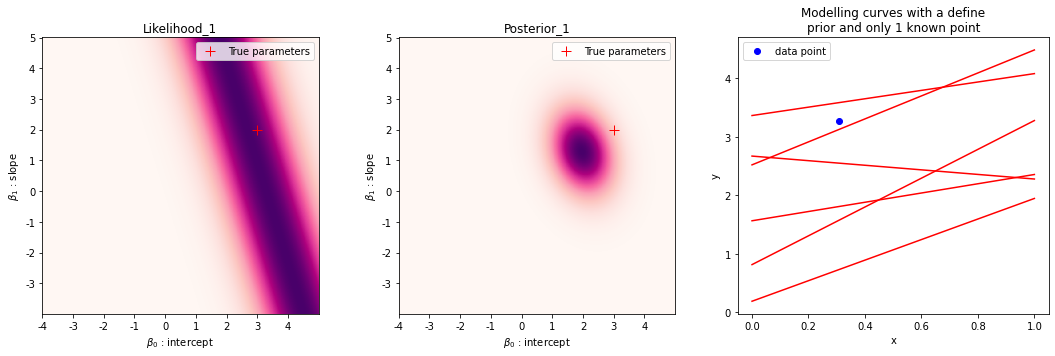

In [228]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(mat_likelihood_1,interpolation='nearest',cmap='RdPu')
ax[0].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[0].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_xticklabels(np.arange(-4, 5, 1))
ax[0].set_yticklabels(np.arange(5, -4, -1))
ax[0].legend(loc='best')
ax[0].set_xlabel(r'$\beta_0$ : intercept')
ax[0].set_title('Likelihood_1')
ax[0].set_ylabel(r'$\beta_1$ : slope')



ax[1].imshow(p_beta_given_y_1,interpolation='nearest',cmap='RdPu')
ax[1].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[1].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_xticklabels(np.arange(-4, 5, 1))
ax[1].set_yticklabels(np.arange(5, -4, -1))

ax[1].legend(loc='best')
ax[1].set_xlabel(r'$\beta_0$ : intercept')
ax[1].set_title('Posterior_1')
ax[1].set_ylabel(r'$\beta_1$ : slope')

ax[2].plot(X[:1,1],y[:1],'bo',label='data point')
for b in betas_1:
    ax[2].plot(x,make_linear_fn(np.concatenate([np.ones((x.shape[0],1)),x[:,np.newaxis]],axis=1),b),'r')
ax[2].legend(loc='best')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('Modelling curves with a define\nprior and only 1 known point')



plt.tight_layout()
plt.show()

In [229]:
mat_likelihood_2=likelihood(X,y,2,np.array([1]),betas_tries)
p_beta_given_y_2=p_beta_given_y(2,X,y,np.eye(2),np.ones(2),betas_tries,1)
covariance_2=S_n(1,np.eye(2),X[:2,:])
mn_2=m_n(covariance_2,np.eye(2),np.ones(2),X[:2,:],y[:2],1)
betas_2=p_beta_given_y_distri(6,mn_2,covariance_2)

Now with 2 points (those 2 randomly sample points) we would be inclined to say that the slope is negative and this is what the likelihood say too. But again thanks to the prior, the posterior is recentered around values that makes more sense to us.

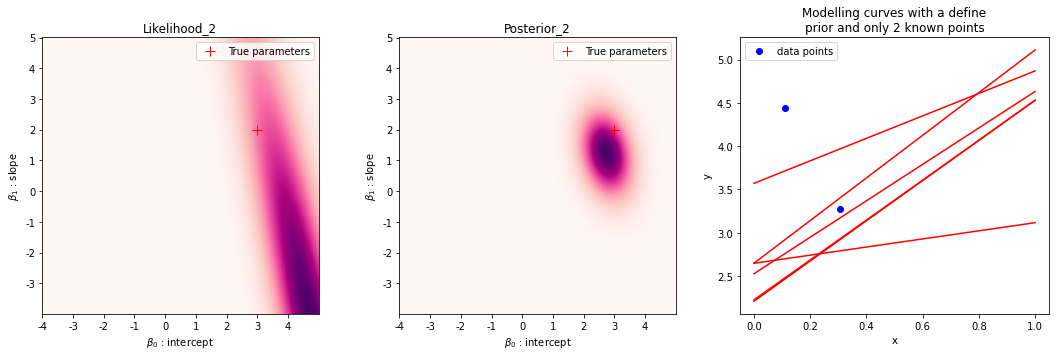

In [230]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(mat_likelihood_2,interpolation='nearest',cmap='RdPu')
ax[0].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[0].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_xticklabels(np.arange(-4, 5, 1))
ax[0].set_yticklabels(np.arange(5, -4, -1))
ax[0].legend(loc='best')
ax[0].set_xlabel(r'$\beta_0$ : intercept')
ax[0].set_title('Likelihood_2')
ax[0].set_ylabel(r'$\beta_1$ : slope')



ax[1].imshow(p_beta_given_y_2,interpolation='nearest',cmap='RdPu')
ax[1].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[1].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_xticklabels(np.arange(-4, 5, 1))
ax[1].set_yticklabels(np.arange(5, -4, -1))

ax[1].legend(loc='best')
ax[1].set_xlabel(r'$\beta_0$ : intercept')
ax[1].set_title('Posterior_2')
ax[1].set_ylabel(r'$\beta_1$ : slope')

ax[2].plot(X[:2,1],y[:2],'bo',label='data points')
for b in betas_2:
    ax[2].plot(x,make_linear_fn(np.concatenate([np.ones((x.shape[0],1)),x[:,np.newaxis]],axis=1),b),'r')
ax[2].legend(loc='best')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('Modelling curves with a define\nprior and only 2 known points')



plt.tight_layout()
plt.show()

In [231]:
mat_likelihood_3=likelihood(X,y,3,np.array([1]),betas_tries)
p_beta_given_y_3=p_beta_given_y(3,X,y,np.eye(2),np.ones(2),betas_tries,1)
covariance_3=S_n(1,np.eye(2),X[:3,:])
mn_3=m_n(covariance_3,np.eye(2),np.ones(2),X[:3,:],y[:3],1)
betas_3=p_beta_given_y_distri(6,mn_3,covariance_3)

Now with 3 points we are a bit luckier. The posterior shrinking compare to the likelihood and the prior, making the estimation of the $\pmb\beta$ easier.

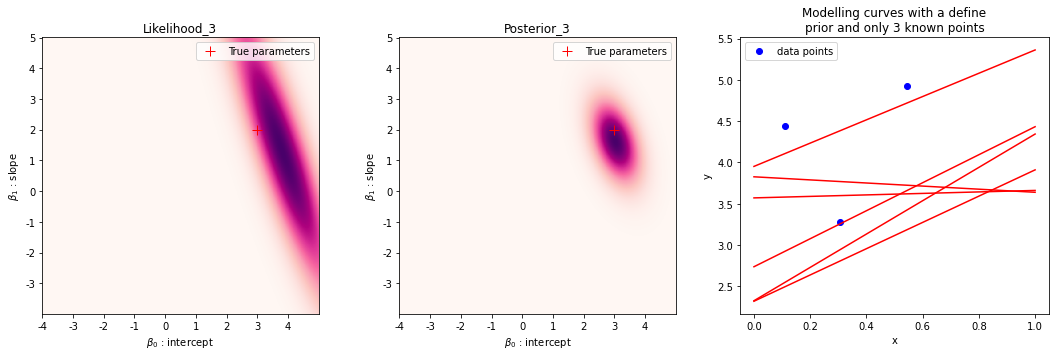

In [232]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(mat_likelihood_3,interpolation='nearest',cmap='RdPu')
ax[0].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[0].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_xticklabels(np.arange(-4, 5, 1))
ax[0].set_yticklabels(np.arange(5, -4, -1))
ax[0].legend(loc='best')
ax[0].set_xlabel(r'$\beta_0$ : intercept')
ax[0].set_title('Likelihood_3')
ax[0].set_ylabel(r'$\beta_1$ : slope')



ax[1].imshow(p_beta_given_y_3,interpolation='nearest',cmap='RdPu')
ax[1].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[1].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_xticklabels(np.arange(-4, 5, 1))
ax[1].set_yticklabels(np.arange(5, -4, -1))

ax[1].legend(loc='best')
ax[1].set_xlabel(r'$\beta_0$ : intercept')
ax[1].set_title('Posterior_3')
ax[1].set_ylabel(r'$\beta_1$ : slope')

ax[2].plot(X[:3,1],y[:3],'bo',label='data points')
for b in betas_3:
    ax[2].plot(x,make_linear_fn(np.concatenate([np.ones((x.shape[0],1)),x[:,np.newaxis]],axis=1),b),'r')
ax[2].legend(loc='best')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('Modelling curves with a define\nprior and only 3 known points')



plt.tight_layout()
plt.show()

In [233]:
mat_likelihood_100=likelihood(X,y,100,np.array([1]),betas_tries)
p_beta_given_y_100=p_beta_given_y(100,X,y,np.eye(2),np.ones(2),betas_tries,1)
covariance_100=S_n(1,np.eye(2),X[:100,:])
mn_100=m_n(covariance_100,np.eye(2),np.ones(2),X[:100,:],y[:100],1)
betas_100=p_beta_given_y_distri(6,mn_100,covariance_100)

Finally with hundred point, the likelihood and the posterior look quite alike with the exception that the posterior is a bit more schrinken. Moreover the red line that are different probable model are almost superimposed (obviously since the $\pmb\beta$ they are made of are also close to each other due to the schrinken posterior), and really start to look like the real regression line. 

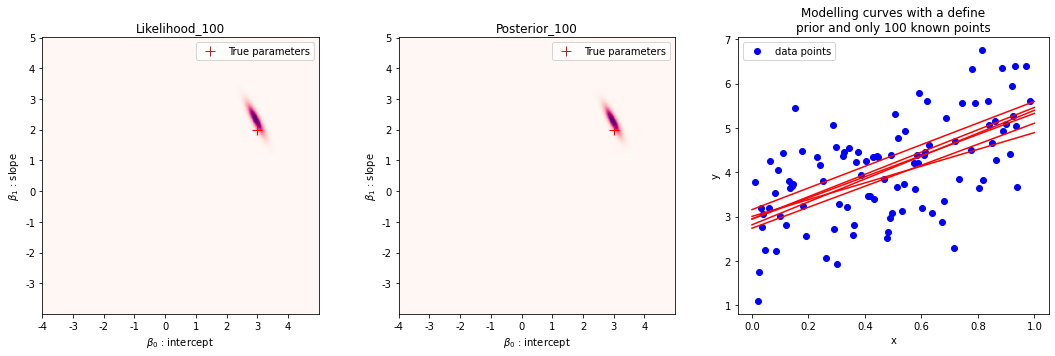

In [234]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(mat_likelihood_100,interpolation='nearest',cmap='RdPu')
ax[0].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[0].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[0].set_xticklabels(np.arange(-4, 5, 1))
ax[0].set_yticklabels(np.arange(5, -4, -1))
ax[0].legend(loc='best')
ax[0].set_xlabel(r'$\beta_0$ : intercept')
ax[0].set_title('Likelihood_100')
ax[0].set_ylabel(r'$\beta_1$ : slope')



ax[1].imshow(p_beta_given_y_100,interpolation='nearest',cmap='RdPu')
ax[1].plot([true_intercept_matrix],[true_slope_matrix],'r+',markersize=10,label='True parameters')
ax[1].set_xticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_yticks(np.arange(0,betas_tries[1].shape[0],100))
ax[1].set_xticklabels(np.arange(-4, 5, 1))
ax[1].set_yticklabels(np.arange(5, -4, -1))

ax[1].legend(loc='best')
ax[1].set_xlabel(r'$\beta_0$ : intercept')
ax[1].set_title('Posterior_100')
ax[1].set_ylabel(r'$\beta_1$ : slope')

ax[2].plot(X[:100,1],y[:100],'bo',label='data points')
for b in betas_100:
    ax[2].plot(x,make_linear_fn(np.concatenate([np.ones((x.shape[0],1)),x[:,np.newaxis]],axis=1),b),'r')
ax[2].legend(loc='best')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('Modelling curves with a define\nprior and only 100 known points')



plt.tight_layout()
plt.show()

Now we could draw 1000 of those $\pmb\beta$ from the posterior , and draw 100 of those red lines instead of 6 for now. This would allow us to estimate the variability in possible models : i.e. how wide or narrow our understanding of the $\bar y_i$ is. Again I would like to remind you that those linear model actually model $\bar y_i$ which is this hypothetical mean of $y_i$ given $x_i$. If you remember well we wrote before :
$$p(y_i|\bar{y_i},\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}}*\exp(-\frac{1}{2}\frac{(y_i-\bar{y_i})^2}{\sigma^2})$$
and with the assumption of linear modeling
$$\bar{y_i}=\pmb\beta^{T}\pmb X_i$$

we write

$$y_i\sim \mathcal{N} (\pmb\beta^{T}\pmb X_i,\sigma²)$$

Basically by doing that we would be able to have confidence interval driven by our model uncertainty, around the true ligne of regression which is actually this $\{\bar y_i\}_{i=1,..,N}$.

So let's do just that.

In [235]:
betas_100_1000=p_beta_given_y_distri(1000,mn_100,covariance_100)

In [236]:
pred=np.zeros((1000,x.shape[0]))
for i,b in enumerate(betas_100_1000):
    pred[i]=make_linear_fn(np.concatenate([np.ones((x.shape[0],1)),x[:,np.newaxis]],axis=1),b)

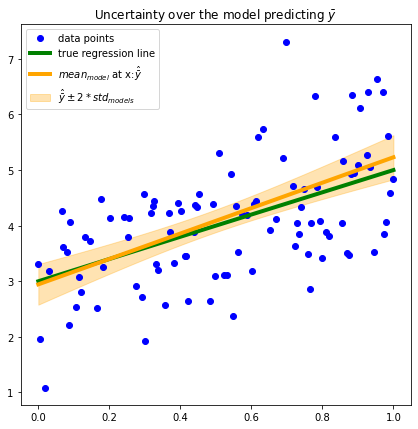

In [327]:
plt.figure(figsize=(7, 7))
plt.plot(X[:100,1],y[:100],'bo',label='data points')
plt.plot(x, true_regression_line,'green', label="true regression line", lw=4.0)
y_mean= np.mean(pred,axis=0)
y_std= np.std(pred,axis=0)
plt.plot(x, np.mean(pred,axis=0),'orange', label=r"$mean_{model}$ at x:$\hat\bar y$", lw=4.0)
plt.fill_between(x,
                       [m-2*s for m,s in zip(y_mean,y_std)],
                       [m+2*s for m,s in zip(y_mean,y_std)],
                       alpha=0.3,color='orange',label=r'$\hat\bar y\pm2*std_{models}$')
plt.legend(loc='best')
plt.title(r'Uncertainty over the model predicting $\bar y$')
plt.show()


Basically the shading area correspond to the 95% of probability to find one of the red line in the third panel of above graph.

But what we usually are really interested in is how our model handle the variations in y.

The bayesian framework allows us to have access to that through an integral that we can either calculate or approximate by Monte Carlo methods.

$$p(y_{new}\mid \pmb y_{training},\pmb X_{training},\pmb X_{new})=\int p(y_{new}\mid\pmb\beta,\pmb X_{new})p(\pmb\beta \mid \pmb y_{training},\pmb x_{training})d\pmb\beta$$

This can be read as : the probability to have a new data point y associated to a new measure x, given a set of known pairs of  $\pmb y$ and $\pmb X$ on which you trained you model is equal to the probability to have $y_{new}$ given $x_{new}$ and some parameters $\pmb \beta$. This probability is averaged over the posterior probability to have $\pmb \beta$ given our training set $y_{training}$, $x_{training}$ .

Here as we are alway using gaussain every where : an analytical solution exist and so Monte Carlo Methods to approximate that integral are not necessary.

In [283]:
def std_analytical(epsilon,X,S_n):
    matrix=np.zeros((X.shape[0],1))
    for n in range(matrix.shape[0]):
        matrix[n]=1./epsilon+X[n,:].T@S_n@X[n,:]
    return matrix

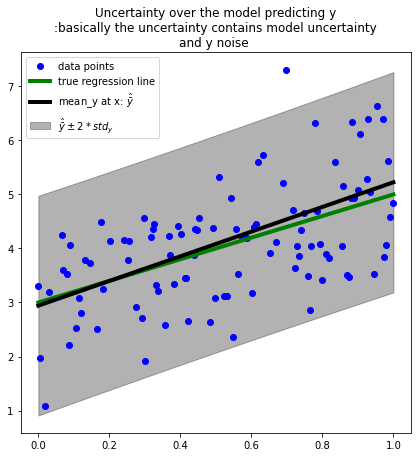

In [328]:
plt.figure(figsize=(7, 7))
plt.plot(X[:100,1],y[:100],'bo',label='data points')
plt.plot(x, true_regression_line,'green', label="true regression line", lw=4.0)
xx=np.concatenate([np.ones((x.shape[0],1)),x[:,np.newaxis]],axis=1)
y_mean= mn_100@xx.T
y_std= std_analytical(1,xx,covariance_100)


plt.plot(x, y_mean,'k', label=r"mean_y at x: $\hat\bar y$", lw=4.0)
plt.fill_between(x,
                       [m-2*s**0.5 for m,s in zip(y_mean,y_std.flatten())],
                       [m+2*s**0.5 for m,s in zip(y_mean,y_std.flatten())],
                       alpha=0.3,color='k',label=r'$\hat\bar y\pm2*std_y$')
plt.legend(loc='best')
plt.title('Uncertainty over the model predicting y\n:basically the uncertainty contains model uncertainty\nand y noise ')
plt.show()


Since again everything is gaussian here, so taking 2*std is 95% confidence interval, which goes well with the only few points out of the shading.

# Basic Modelling

## Gaussian

In [5]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
size = 200
true_intercept = 0
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=1, size=size)

data = pd.DataFrame(dict(x=x, y=y))

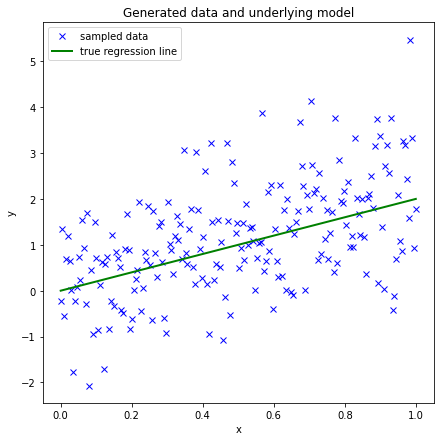

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "bx", label="sampled data")
ax.plot(x, true_regression_line,'green', label="true regression line", lw=2.0)
plt.legend(loc=0);


### GLM

In [11]:
import statsmodels
import statsmodels.api as sm


X = sm.add_constant(x)#the model doesn't include an intercept automatically so we creat one



# a GLM with gaussian error model, and identity as a link function
modelGLM = sm.GLM(y, X , family=sm.families.Gaussian( sm.families.links.identity() ) )


resultsGLM = modelGLM.fit()#we do the actual fit



print(resultsGLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      198
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.0851
Method:                          IRLS   Log-Likelihood:                -290.95
Date:                Thu, 24 Mar 2022   Deviance:                       214.85
Time:                        10:41:15   Pearson chi2:                     215.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0921      0.147      0.628      0.5

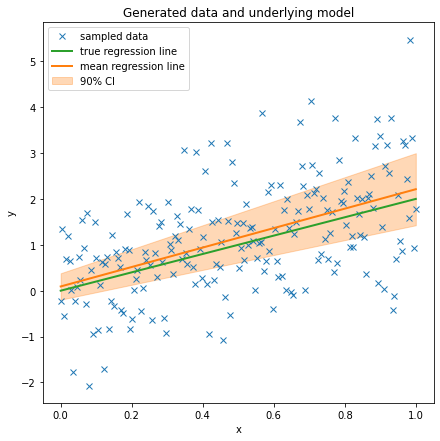

In [332]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "bx", label="sampled data")
ax.plot(x, true_regression_line,'C2', label="true regression line",lw=2.0)
ax.plot(x, [xx*resultsGLM.params[1]+resultsGLM.params[0] for xx in x],'C1', label="mean regression line",lw=2.0)

ax.fill_between(x,
                   [xx*resultsGLM.params[1] -xx*1.96*resultsGLM.bse[1]+resultsGLM.params[0]-1.96*resultsGLM.bse[0] for xx in x],
                   [xx*resultsGLM.params[1]+xx*1.96*resultsGLM.bse[1]+resultsGLM.params[0]+1.96*resultsGLM.bse[0] for xx in x],color='C1',
                   alpha=0.3,label='90% CI')

plt.legend(loc=0);

### Bayesian Probabilistic Modelling

In [499]:
with pm.Model() as gaussian_uniform_prior:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    x_obs = pm.Data('x',data['x'])
    y_obs = pm.Data('y',data['y'])
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Uniform("Intercept", -5, 5)
    x_coeff = pm.Uniform("x_coeff", -5,5)
    mu=pm.Deterministic('mu',intercept + x_coeff * x_obs)
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_obs)

In [500]:
with gaussian_uniform_prior:
    trace_gaussian_uniform_prior = pm.sample(4000,tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_coeff, Intercept, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.6819785667723401, but should be close to 0.8. Try to increase the number of tuning steps.


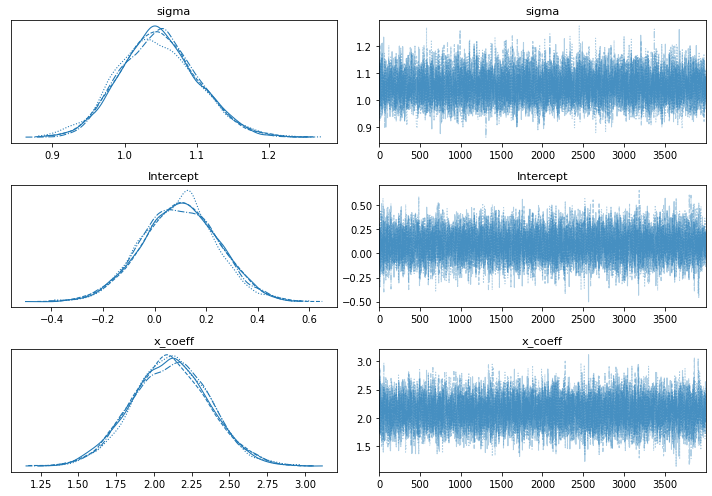

In [501]:
az.plot_trace(trace_gaussian_uniform_prior, figsize=(10, 7),var_names=["sigma", "Intercept", "x_coeff"])
plt.tight_layout()
plt.show()


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


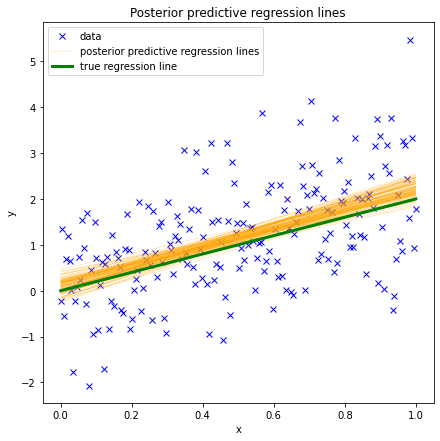

In [502]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "bx", label="data")
pm.plot_posterior_predictive_glm(trace_gaussian_uniform_prior,
                                 lm=lambda x, sample: sample['Intercept'] + sample['x_coeff'] * x,samples=100, label="posterior predictive regression lines",color='orange')
plt.plot(x, true_regression_line,'green', label="true regression line", lw=3.0)

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


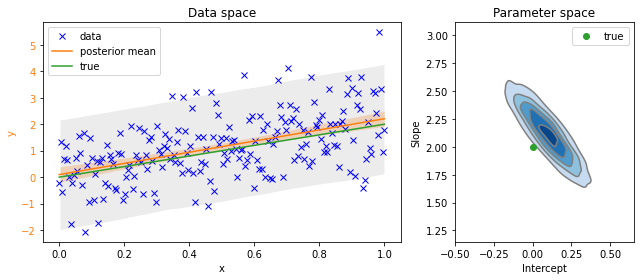

In [505]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    trace_gaussian_uniform_prior.posterior.mu,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

new_x=np.arange(0,1,0.001)
with gaussian_uniform_prior:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_gaussian_uniform_prior,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

ax[0].plot(data["x"], data["y"], 'bx', label="data")
# posterior mean
mu_mean = trace_gaussian_uniform_prior.posterior.stack(sample=("chain", "draw")).mu.mean("sample")
ax[0].plot(data["x"], mu_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], true_regression_line, label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("y", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis


# get y-axes to line up


# Parameter space plot ===================================================
az.plot_kde(
    trace_gaussian_uniform_prior.posterior.stack(sample=("chain", "draw")).Intercept.values,
    trace_gaussian_uniform_prior.posterior.stack(sample=("chain", "draw")).x_coeff.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(true_intercept, true_slope, "C2o", label="true")
ax[1].set(xlabel='Intercept', ylabel='Slope', title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

## Gaussian Ridge

Ridge regression is very common in classical Machine Learning and Deep Learning. To me at least, from the prespective of the frequentist framework that mainstream classical Machine Learning and Deep Learning usaully use, the form of the regularization is a bit out the blue. I never really understood why poeple decide to use the $\frac{1}{C}\Sigma^{p}_{m=1}\beta_{m}^{2}$ form as a regulariser. I had the intuition of why it was working, but no intuition about why it would make sense to use this form, and to where it was coming from.


MAP give it a very obvious signification : the Ridge regularization appears naturally if you consider a Gaussian prior for your $\pmb\beta\sim \mathcal{N}(\mu,\sigma²)$. In the particular form use above $\mu=0$. Moreover $C=2\sigma²$ and so you are weighting your regularization by how much you believe a priori that your $\pmb\beta$ are peaked around a certain value -> so clearly this transcribed to your trust in how you understand what you are trying to model.

### The Bayesian way

In [506]:
with pm.Model() as gaussian_ridge:  # model specifications in PyMC3 are wrapped in a with-statement
    x_obs = pm.Data('x',data['x'])
    y_obs = pm.Data('y',data['y'])
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=1)
    x_coeff = pm.Normal("x_coeff",0, sigma=1)
    mu=pm.Deterministic('mu',intercept + x_coeff * x_obs)
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_obs)

In [507]:
with gaussian_ridge:
    trace_gaussian_ridge = pm.sample(4000,tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_coeff, Intercept, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 7 seconds.


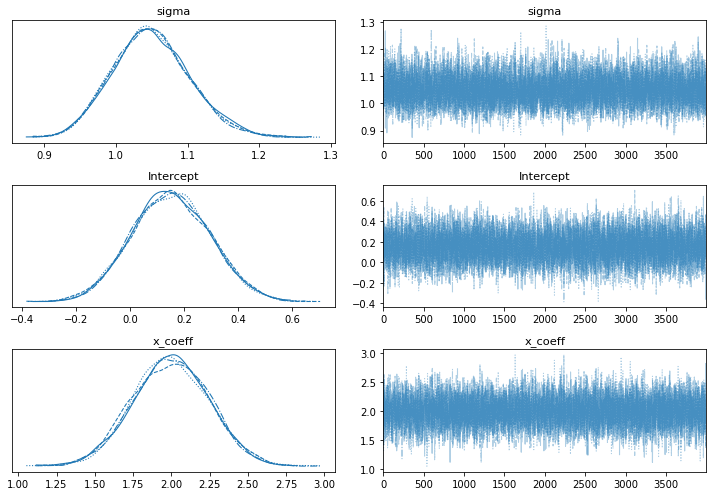

In [508]:
az.plot_trace(trace_gaussian_ridge, figsize=(10, 7),var_names=["sigma", "Intercept", "x_coeff"])
plt.tight_layout()
plt.show()


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


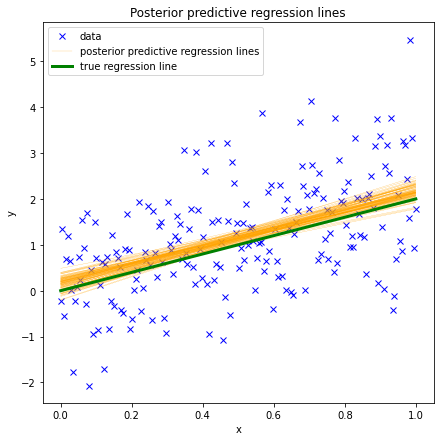

In [509]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "bx", label="data")
pm.plot_posterior_predictive_glm(trace_gaussian_ridge,
                                 lm=lambda x, sample: sample['Intercept'] + sample['x_coeff'] * x,samples=100, label="posterior predictive regression lines",color='orange')
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="green")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


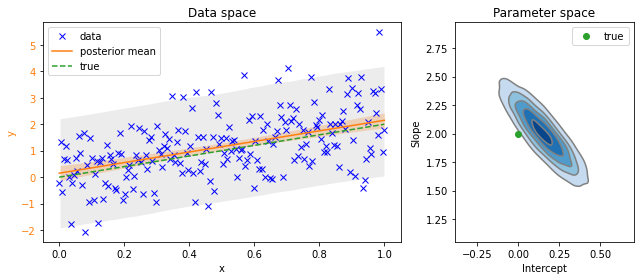

In [510]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    trace_gaussian_ridge.posterior.mu,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

new_x=np.arange(0,1,0.001)
with gaussian_ridge:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_gaussian_ridge,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)


ax[0].plot(data["x"], data["y"], 'bx', label="data")
# posterior mean
mu_mean = trace_gaussian_ridge.posterior.stack(sample=("chain", "draw")).mu.mean("sample")
ax[0].plot(data["x"], mu_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], true_regression_line, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("y", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis



# Parameter space plot ===================================================
az.plot_kde(
    trace_gaussian_ridge.posterior.stack(sample=("chain", "draw")).Intercept.values,
    trace_gaussian_ridge.posterior.stack(sample=("chain", "draw")).x_coeff.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(true_intercept, true_slope, "C2o", label="true")
ax[1].set(xlabel='Intercept', ylabel='Slope', title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

### GLM

You could of course solve this problem the frequentist way using statsmodel or scikitlearn. You will be missing all the beauty of the credence interval on $y$, and more meaningfull (to me) credence interval around the $\pmb\beta$. But at the same time solving the problem would be faster.

As an example we are going to use scikitlearn because statsmodel in that particular case of regularization, is really horrible to use. 

Generally speaking scikitlearn is a great library for classical machine learning (like ridge regression) and I use it almost daily. I really encourage you to check all the things you can do with it.

Here the `alpha` is the coeffcient in front of the regularization. Since above we decide to use a gaussian prior with standard deviation 1 then for good comparison the  $\alpha=\frac{1}{2*1}=0.5$

In [231]:
from sklearn.linear_model import Ridge

GLM_Gaussian_Ridge = Ridge(alpha=0.5)
GLM_Gaussian_Ridge.fit(X, y)


Ridge(alpha=0.5)

In [240]:
print(f"Intercept :{GLM_Gaussian_Ridge.coef_[0]}, Slope:{GLM_Gaussian_Ridge.coef_[1]:.4f}")

Intercept :0.0, Slope:2.0583


As you can see this is quite good. But you don't have much about parameter confidence interval and model credence interval. If this was a course on Machine Learning I would introduced better way to work with this library, but this is out of the scope today.

## Gaussian Lasso

Let's do a Lasso regularization with a $y$ normaly distributed.

In this regularization, you have a Laplace prior instead of a Gaussian prior.

$\mathcal{L}(\beta\mid\mu,\lambda)=\frac{1}{2\lambda}e^{-\frac{\mid \beta-\mu \mid}{\lambda}}$

This will lead to this MAP :

$$\pmb\beta_{MAP} = argmax_{\pmb\beta} \text{ }-\frac{1}{2\sigma²}*\sum_i (y_i-\pmb\beta^{T}\pmb X_i)² -\frac{1}{\lambda}*\sum_p\mid\beta_p\mid$$


You see now that that instead of having a regularisation which is squared of $\beta$s , it si now its absolute value.

This is interesting because it leads to a collapse to the unecessary $\beta$ to 0 rather than toward small but non 0 values. In classical machine learning people like that because it allows to simplifying the model kind of automatically : if a feature turns out to be not specially worth keeping it will end up being multiply by 0.

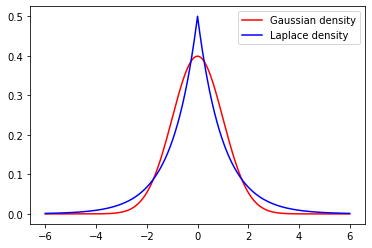

In [4]:
x_=np.arange(-6,6,0.005)
plt.plot(x_, stats.norm.pdf( x_ , loc = 0 , scale = 1 ) ,'r',label='Gaussian density')
plt.plot(x_, stats.laplace.pdf( x_ , loc = 0 , scale = 1 ) ,'b',label='Laplace density')
plt.legend(loc='best')
plt.show()

In [7]:
with pm.Model() as gaussian_lasso:  # model specifications in PyMC3 are wrapped in a with-statement
    x_obs = pm.Data('x',data['x'])
    y_obs = pm.Data('y',data['y'])
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Laplace("Intercept", 0, b=1)
    x_coeff = pm.Laplace("x_coeff",0, b=1)
    mu=pm.Deterministic('mu',intercept + x_coeff * x_obs)
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_obs)

In [8]:
with gaussian_lasso:
    trace_gaussian_lasso = pm.sample(4000,tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_coeff, Intercept, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8841047820227448, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7213418580573713, but should be close to 0.8. Try to increase the number of tuning steps.


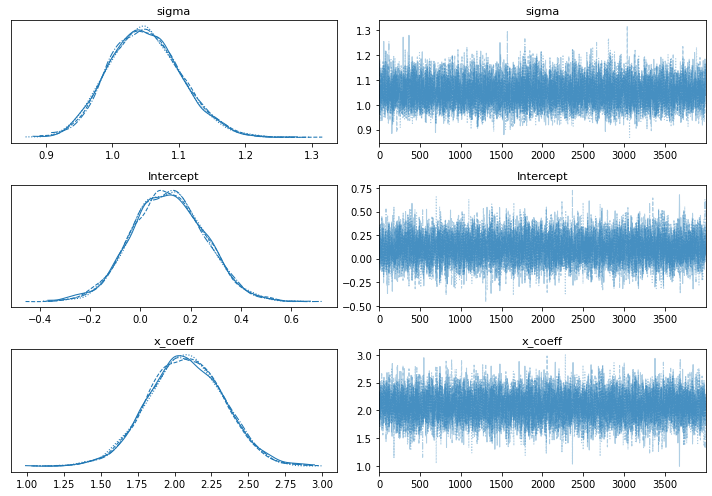

In [9]:
az.plot_trace(trace_gaussian_lasso, figsize=(10, 7),var_names=["sigma", "Intercept", "x_coeff"])
plt.tight_layout()
plt.show()


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


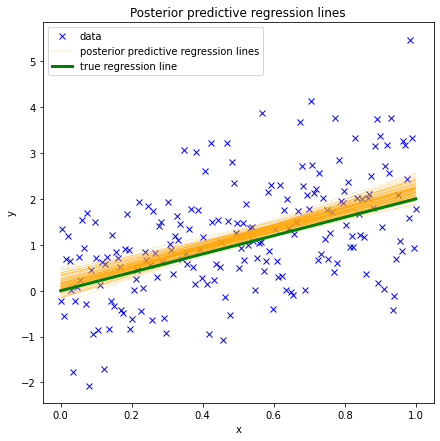

In [514]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "bx", label="data")
pm.plot_posterior_predictive_glm(trace_gaussian_lasso,
                                 lm=lambda x, sample: sample['Intercept'] + sample['x_coeff'] * x,samples=100, label="posterior predictive regression lines",color='orange')
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="green")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


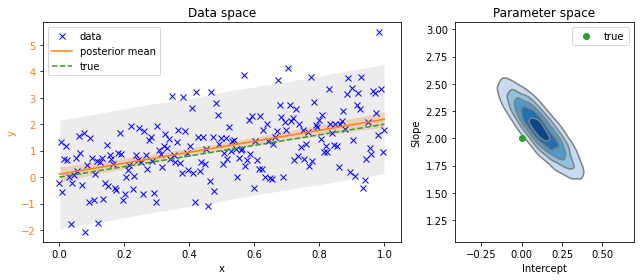

In [515]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    trace_gaussian_lasso.posterior.mu,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
new_x=np.arange(0,1,0.001)
with gaussian_lasso:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_gaussian_lasso,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)


ax[0].plot(data["x"], data["y"], 'bx', label="data")

# posterior mean
mu_mean = trace_gaussian_lasso.posterior.stack(sample=("chain", "draw")).mu.mean("sample")
ax[0].plot(data["x"], mu_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], true_regression_line, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("y", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()





# Parameter space plot ===================================================
az.plot_kde(
    trace_gaussian_lasso.posterior.stack(sample=("chain", "draw")).Intercept.values,
    trace_gaussian_lasso.posterior.stack(sample=("chain", "draw")).x_coeff.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(true_intercept, true_slope, "C2o", label="true")
ax[1].set(xlabel='Intercept', ylabel='Slope', title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

In [26]:
from sklearn.linear_model import Lasso

GLM_Gaussian_Lasso = Lasso(alpha=1)
GLM_Gaussian_Lasso.fit(X, y)


Lasso(alpha=1)

In [27]:
print(f"Intercept :{GLM_Gaussian_Lasso.coef_[0]}, Slope:{GLM_Gaussian_Lasso.coef_[1]:.4f}")

Intercept :0.0, Slope:0.0000


## Robust regression

So far we have say that our target variable y was Gaussian. We have also see that from the perspective of the GLM and Bayesian framework, we can also work with y that would be produce by other distribution like Poisson or Binomial etc... And we will see example of that later.

One other distribution for y that we could already lookt at is a Student T distribution. This distribution is looking really much like a Gaussian but with longer tails.

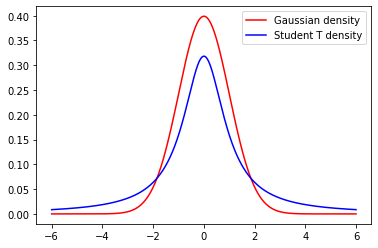

In [516]:
x_=np.arange(-6,6,0.005)
plt.plot(x_, stats.norm.pdf( x_ , loc = 0 , scale = 1 ) ,'r',label='Gaussian density')
plt.plot(x_, stats.t.pdf( x_ ,df=1, loc = 0 , scale = 1 ) ,'b',label='Student T density')
plt.legend(loc='best')
plt.show()

By using a Student T distribution we allow for the model to not be bother too much by outliers : their weight in the model will be less important than in the Gaussian framework, has the Student model allows more easily for those extreme event with its fatter tails.

In [517]:
size = 100
true_intercept = 1
true_slope = 2

x_out = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line_out = true_intercept + true_slope * x_out
# add noise
y_out = true_regression_line_out + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out_f = np.append(x_out, [0.1, 0.15, 0.2,0.8])
y_out_f = np.append(y_out, [8, 6, 9, 7])

data_out = dict(x=x_out_f, y=y_out_f)

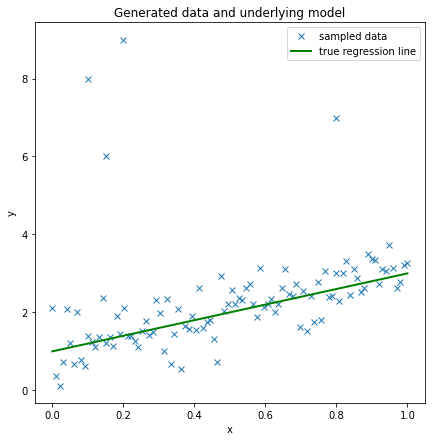

In [518]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out_f, y_out_f, "x", label="sampled data")
ax.plot(x_out, true_regression_line_out,'green', label="true regression line", lw=2.0)
plt.legend(loc=0)
plt.show()

### Let's start with a basic Gaussian

In [519]:
with pm.Model() as gaussian_uniform_prior_outliers:  # model specifications in PyMC3 are wrapped in a with-statement
    x_obs = pm.Data('x',data_out['x'])
    y_obs = pm.Data('y',data_out['y'])
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Uniform("Intercept", -5, 5)
    x_coeff = pm.Uniform("x_coeff", -5,5)
    mu=pm.Deterministic('mu',intercept + x_coeff * x_obs)
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_obs)

In [520]:
with gaussian_uniform_prior_outliers:
    trace_gaussian_uniform_prior_outliers = pm.sample(4000,tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_coeff, Intercept, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.7207522767962762, but should be close to 0.8. Try to increase the number of tuning steps.


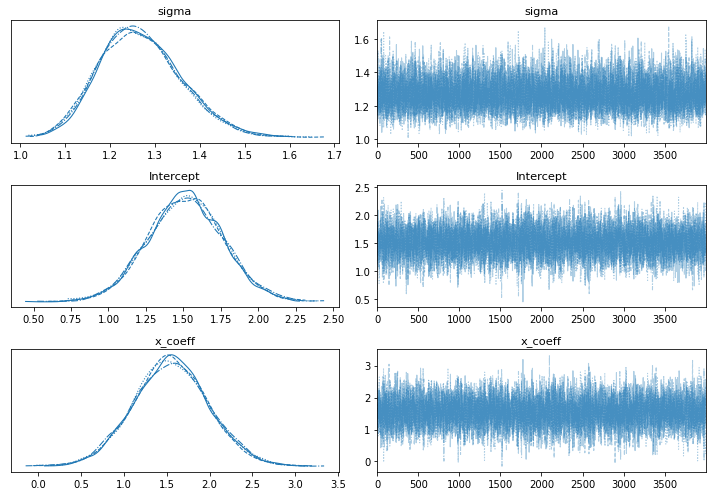

In [521]:
az.plot_trace(trace_gaussian_uniform_prior_outliers, figsize=(10, 7),var_names=["sigma", "Intercept", "x_coeff"])
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


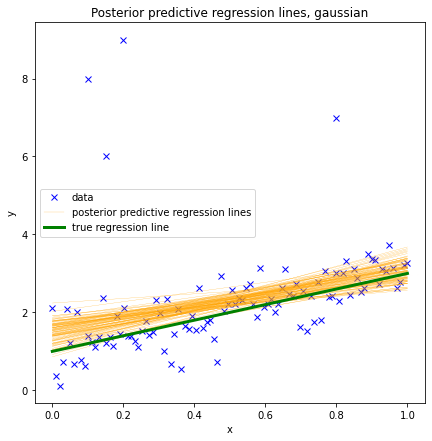

In [522]:
plt.figure(figsize=(7, 7))
plt.plot(x_out_f, y_out_f, "bx", label="data")
pm.plot_posterior_predictive_glm(trace_gaussian_uniform_prior_outliers,
                                 lm=lambda x_out_f, sample: sample['Intercept'] + sample['x_coeff'] * x_out_f,samples=100, label="posterior predictive regression lines",color='orange')
plt.plot(x_out, true_regression_line_out,'green', label="true regression line", lw=3.0)

plt.title("Posterior predictive regression lines, gaussian")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


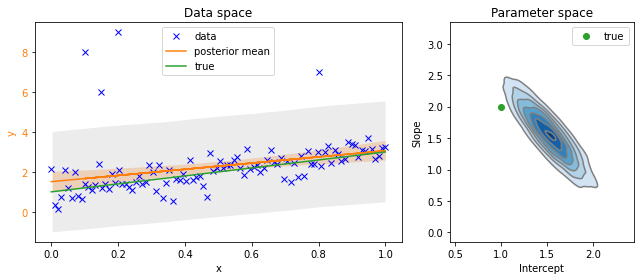

In [523]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data_out["x"],
    trace_gaussian_uniform_prior_outliers.posterior.mu,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
new_x=np.arange(0,1,0.001)
with gaussian_uniform_prior_outliers:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_gaussian_uniform_prior_outliers,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

ax[0].plot(data_out["x"], data_out["y"], 'bx', label="data")
# posterior mean
mu_mean = trace_gaussian_uniform_prior_outliers.posterior.stack(sample=("chain", "draw")).mu.mean("sample")
ax[0].plot(data_out["x"], mu_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(x_out, true_regression_line_out, label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("y", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis


# get y-axes to line up


# Parameter space plot ===================================================
az.plot_kde(
    trace_gaussian_uniform_prior_outliers.posterior.stack(sample=("chain", "draw")).Intercept.values,
    trace_gaussian_uniform_prior_outliers.posterior.stack(sample=("chain", "draw")).x_coeff.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(true_intercept, true_slope, "C2o", label="true")
ax[1].set(xlabel='Intercept', ylabel='Slope', title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

### Robust regression : your y are from a Student Distribution instead of Gaussian

In [524]:
with pm.Model() as student_uniform_prior:  # model specifications in PyMC3 are wrapped in a with-statement
    x_obs = pm.Data('x',data_out['x'])
    y_obs = pm.Data('y',data_out['y'])
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Uniform("Intercept", -5, 5)
    x_coeff = pm.Uniform("x_coeff", -5,5)
    mu=pm.Deterministic('mu',intercept + x_coeff * x_obs)
    nu=pm.Uniform('nu',1,110)
    # Define likelihood
    likelihood = pm.StudentT("obs",nu=nu, mu=mu, sigma=sigma, observed=y_obs)

In [525]:
with student_uniform_prior:
    trace_student_uniform_prior = pm.sample(4000,tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, x_coeff, Intercept, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 10 seconds.


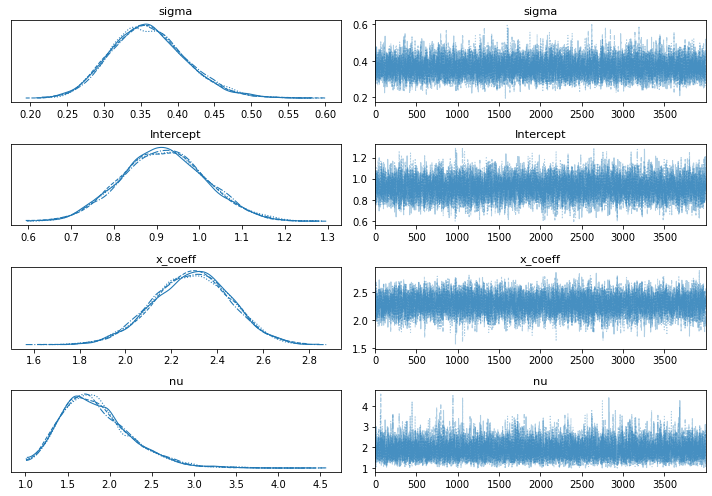

In [526]:
az.plot_trace(trace_student_uniform_prior, figsize=(10, 7),var_names=["sigma", "Intercept", "x_coeff",'nu'])
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


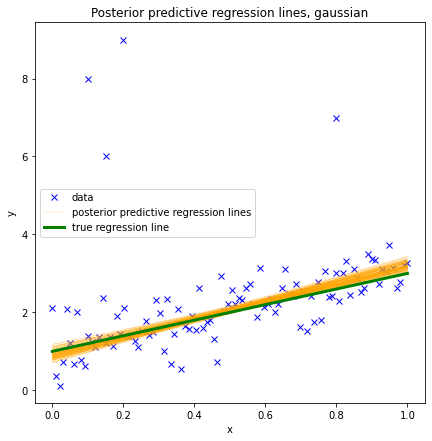

In [527]:
plt.figure(figsize=(7, 7))
plt.plot(x_out_f, y_out_f, "bx", label="data")
pm.plot_posterior_predictive_glm(trace_student_uniform_prior,
                                 lm=lambda x_out_f, sample: sample['Intercept'] + sample['x_coeff'] * x_out_f,samples=100, label="posterior predictive regression lines",color='orange')
plt.plot(x_out, true_regression_line_out,'green', label="true regression line", lw=3.0)

plt.title("Posterior predictive regression lines, gaussian")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


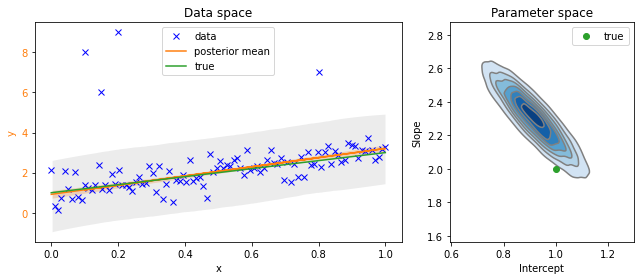

In [528]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data_out["x"],
    trace_student_uniform_prior.posterior.mu,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
new_x=np.arange(0,1,0.001)
with student_uniform_prior:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_student_uniform_prior,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)


ax[0].plot(data_out["x"], data_out["y"], 'bx', label="data")
# posterior mean
mu_mean = trace_student_uniform_prior.posterior.stack(sample=("chain", "draw")).mu.mean("sample")
ax[0].plot(data_out["x"], mu_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(x_out, true_regression_line_out, label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("y", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis


# get y-axes to line up


# Parameter space plot ===================================================
az.plot_kde(
    trace_student_uniform_prior.posterior.stack(sample=("chain", "draw")).Intercept.values,
    trace_student_uniform_prior.posterior.stack(sample=("chain", "draw")).x_coeff.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(true_intercept, true_slope, "C2o", label="true")
ax[1].set(xlabel='Intercept', ylabel='Slope', title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

## Real data

Using data from [TESTING THE RISK-DISTURBANCE HYPOTHESIS IN A FRAGMENTED LANDSCAPE: NONLINEAR RESPONSES OF HOUSE SPARROWS TO HUMANS
Fernández-Juricic(2003),BioOne](https://bioone.org/journals/the-condor/volume-105/issue-2/0010-5422(2003)105%5b0316%3aTTRHIA%5d2.0.CO%3b2/TESTING-THE-RISK-DISTURBANCE-HYPOTHESIS-IN-A-FRAGMENTED-LANDSCAPE/10.1650/0010-5422(2003)105[0316:TTRHIA]2.0.CO;2.short)

In this data set we would like to model the relation between the density of house sparrow nests in a park and how popular a park is.

I encourage you to try to interpret the model :-). The model we are going to use is cubic in number of pedestrian. This is what the paper concludes so this is what we are going to use. But this is typically a good case scenario about how to choose between different models : we will see that later. Because clearly the cubic relationship is not obvious at first...

Text(0.5, 0, 'Number of pedestrians per ha per min')

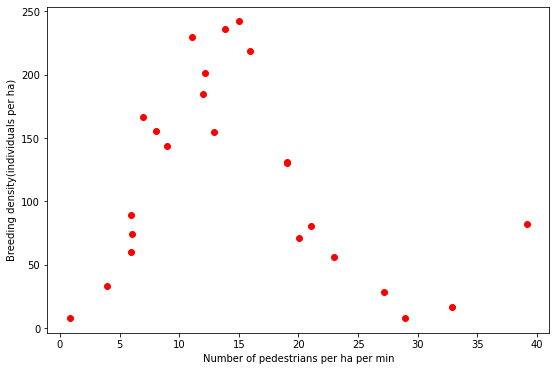

In [529]:
df=pd.read_csv("../Data-pymc/Human_nuisance.csv")
y=np.array(df["Breeding density(individuals per ha)"])
X=np.array(df["Number of pedestrians per ha per min"])

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(X,y,'ro')
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")

In [530]:
data = pd.DataFrame({"x1": X,"x2": X**2,"x3": X**3, "y": y})

In [531]:
data

x1           x2            x3           y
0    0.851146     0.724449      0.616612    7.974940
1    3.973849    15.791479     62.752962   33.316187
2    5.955376    35.466499    211.216326   60.407007
3    5.959888    35.520270    211.696844   89.562266
4    6.039171    36.471590    220.258180   74.250691
5    6.929689    48.020587    332.767727  166.525986
6    8.023098    64.370103    516.447649  155.793890
7    8.945459    80.021239    715.826719  143.380908
8   11.048902   122.078240   1348.830528  229.632304
9   11.976195   143.429239   1717.736491  184.965168
10  12.135553   147.271648   1787.222901  201.549002
11  12.929276   167.166187   2161.337824  155.139749
12  13.875157   192.519981   2671.244963  236.142594
13  15.033918   226.018696   3397.946575  242.020172
14  15.973538   255.153925   4075.710980  218.423357
15  19.003578   361.135984   6862.875915  131.363366
16  19.025082   361.953757   6886.200031  130.643462
17  20.055236   402.212486   8066.466270   71.262837
18  21.063048   443.651981   9344.662859   80.496776
19  22.943172   526.389162  12077.037304   55.744886
20  27.177560   738.619771  20073.883180   28.837369
21  28.945973   837.869368  24252.944332    8.186408
22  32.876904  1080.890784  35536.341999   16.412884
23  39.118581  1530.263383  59861.732163   82.153022

First it would be nice to see what our target variable (here the breeding density of sparrow) is in terms of statistics : gaussian?

Below the normality of our $y$ is not obvious, but this is most of the time a poor choice of plotting and testing normality.

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


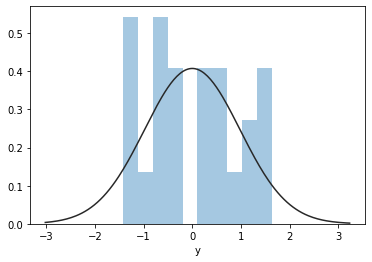

In [532]:
sns.distplot((data.y-data.y.mean())/data.y.std(),10,fit=norm,norm_hist=True,kde=False)

plt.show()

A better way to asses data normality is to use a shapiro test for which the null hypothesis is normality. So here a big p value would lead to the imossibnility to reject the hypothesis that the data is normally distributed.

In [533]:
c=stats.shapiro(data.y)
print('W statistic is {0} and p-value is {1}'.format(c[0], c[1]))


W statistic is 0.9374364018440247 and p-value is 0.1429842710494995


So the Shapiro test is saying that it might well be normally distributed... We have other way to see if we believe that.  One way to do so is to plot the Probability-Probablity plot and the Quantile-Quantile plot

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


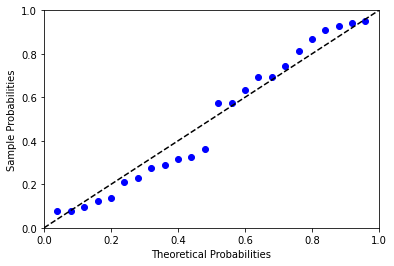

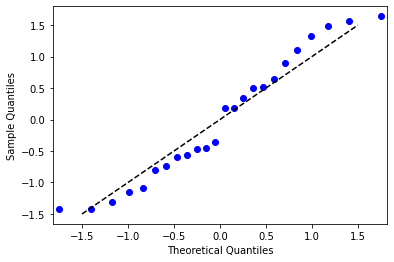

In [534]:
scaled_data=(data.y-data.y.mean())/data.y.std()
pb=statsmodels.graphics.gofplots.ProbPlot(scaled_data)
pb.ppplot()
plt.plot([0,1],[0,1],'k--')
pb.qqplot()
plt.plot([-1.5,1.5],[-1.5,1.5],'k--')
plt.show()

Trully the theoritical measure (with gaussian hypotesis) and the data are very much aligned on the diagonal, which again is a good sign for normality.

Yet something bother me. If you look at the graph breeding sparrow vs pedestrian the varibility of breeding around the same number of pedestrian seems quite big.

Hence I would rather go for a distribution that is almost Gaussian but which allows big variability : Student T.

Hence we are going to do a robust regression.



In [537]:
with pm.Model() as human_nuisance_lasso:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    x1_obs = pm.Data('x1',data['x1'])
    x2_obs = pm.Data('x2',data['x2'])
    x3_obs = pm.Data('x3',data['x3'])
    y_obs = pm.Data('y',data['y'])
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Laplace("Intercept", 0, b=10)
    x_coeff_1 = pm.Laplace("x_coeff_1",0, b=10)
    x_coeff_2 = pm.Laplace("x_coeff_2",0, b=10)
    x_coeff_3 = pm.Laplace("x_coeff_3",0, b=10)
    
    mu=pm.Deterministic('mu',intercept + x_coeff_1* x1_obs+ x_coeff_2* x2_obs+ x_coeff_3* x3_obs)
    nu=pm.Uniform('nu',1,100)
    # Define likelihood
    likelihood = pm.StudentT("obs",nu=nu, mu=mu, sigma=sigma, observed=y_obs)

In [538]:
with human_nuisance_lasso:
    trace_human_nuisance_lasso = pm.sample(4000,tune=8000, return_inferencedata=True,target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, x_coeff_3, x_coeff_2, x_coeff_1, Intercept, sigma]


Sampling 4 chains for 8_000 tune and 4_000 draw iterations (32_000 + 16_000 draws total) took 88 seconds.
The number of effective samples is smaller than 25% for some parameters.


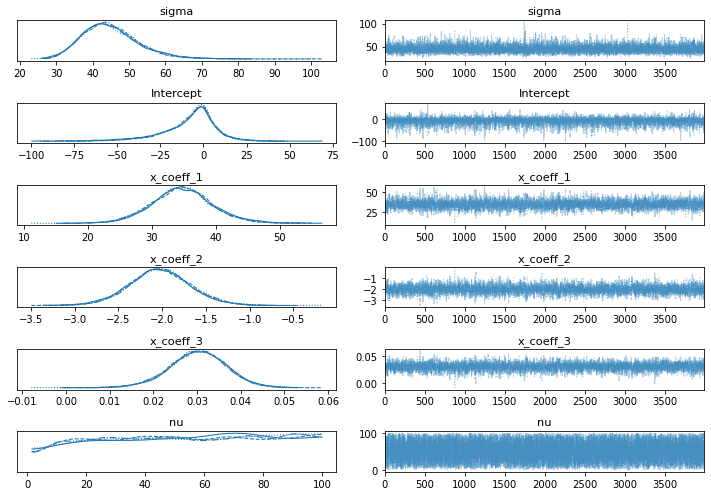

In [539]:
az.plot_trace(trace_human_nuisance_lasso, figsize=(10, 7),var_names=["sigma", "Intercept", "x_coeff_1", "x_coeff_2", "x_coeff_3",'nu'])
plt.tight_layout()
plt.show()


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


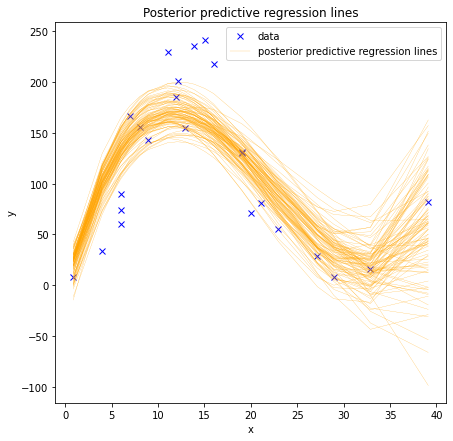

In [540]:
plt.figure(figsize=(7, 7))
plt.plot(X, y, "bx", label="data")
pm.plot_posterior_predictive_glm(trace_human_nuisance_lasso,eval=X,
                                 lm=lambda X, sample: sample['Intercept'] + sample['x_coeff_1'] * X +sample['x_coeff_2'] *X**2+ sample['x_coeff_3'] * X**3,samples=100, label="posterior predictive regression lines",color='orange')


plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


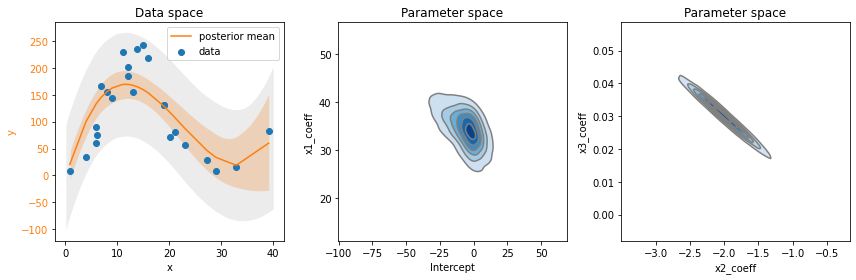

In [542]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Data space plot ========================================================
az.plot_hdi(
    data["x1"],
    trace_human_nuisance_lasso.posterior.mu,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

new_x=np.linspace(0,40,1000)
with human_nuisance_lasso:
    pm.set_data({'x1': new_x,'x2':new_x**2,'x3':new_x**3})
    ppc = pm.sample_posterior_predictive(trace_human_nuisance_lasso,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

# posterior mean
mu_mean = trace_human_nuisance_lasso.posterior.stack(sample=("chain", "draw")).mu.mean("sample")
ax[0].plot(data["x1"], mu_mean, label="posterior mean", color="C1")
ax[0].scatter(data["x1"], data["y"], label="data")
# plot truth

# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("y", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()



# Parameter space plot ===================================================
az.plot_kde(
    trace_human_nuisance_lasso.posterior.stack(sample=("chain", "draw")).Intercept.values,
    trace_human_nuisance_lasso.posterior.stack(sample=("chain", "draw")).x_coeff_1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)

ax[1].set(xlabel='Intercept', ylabel='x1_coeff', title="Parameter space")
az.plot_kde(
    trace_human_nuisance_lasso.posterior.stack(sample=("chain", "draw")).x_coeff_2.values,
    trace_human_nuisance_lasso.posterior.stack(sample=("chain", "draw")).x_coeff_3.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[2],
)

ax[2].set(xlabel='x2_coeff', ylabel='x3_coeff', title="Parameter space")

plt.tight_layout()
plt.show()

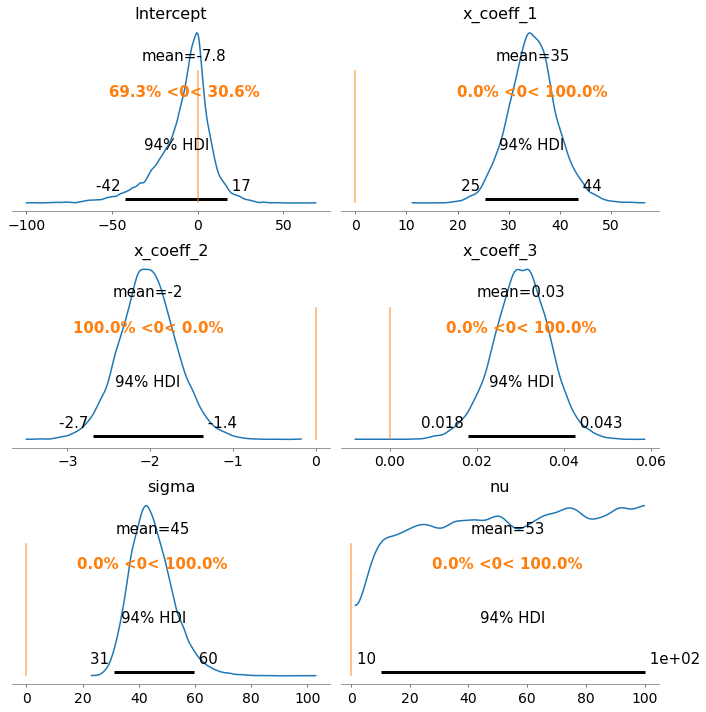

In [543]:
[fig, axes] = plt.subplots(3, 2, figsize=(10, 10))
az.plot_posterior(trace_human_nuisance_lasso, var_names=["Intercept", "x_coeff_1", "x_coeff_2", "x_coeff_3",'sigma','nu'], 
                  ref_val=0,ax=axes)
plt.tight_layout()
plt.show()

I should spend a bit more time interpreting those plots

## Binomial

The binomial distribution gives you the probability of k success wihtin n tries given the probability $p$ that a success occurs at every try.

Binomial distribution could be modeling an experiment where in a box you have a fraction $p$ of red balls and $1-p$ blue balls. You draw n balls from the box, and find k red balls : the binomial distribution will describe the probability of such a result happening.

$$\mathcal{B}(k,n)=\binom{n}{k}p^k(1-p)^{n-k}$$

With 

$$\binom{n}{k} = \frac{n!}{k!(n-k)!}$$


So given $n$ draws you can see that the average value of number of success is $np$.

Recalling that in the framework of GLM we allow the average(here the average number of successes $\bar{k}_i$) to be described by a non linear function (inverse link function $g^{-1}$) of a linear function of the explanatory variables ($\pmb{\beta}^{T}\pmb{X}_{i}$)

We are going to write the probability of a success in a try :

$$p_i=\frac{1}{1+e^{-\pmb{\beta}^{T}\pmb{X}_{i}}}$$

This function above is called the `expit` function. This form for the proability of success follow the hypothesis that the log odds ration are linearly described by the explanatory variables.

$$log( \frac{p_i}{(1-p_i)} )=\pmb{\beta}^{T}\pmb{X}_{i}$$

Note : 
- a binomial experiment is just a sum of Bernouilli experiment : meaning that a Benrouilli experiment contains only 1 draw. This Bernouilli experiment/distribution allow you to model a variable of interest into 2 classes. By trying to understand what explanatory variables are important to differentiate between classes you are doing a logistic regression. Hence a logistic regression is just a GLM for a Bernouilli random variable, which is nothing more than what we did above but with $n=1$.
- The binomial experiement is one that is done with replacement : you put back the balls in the box at the end of every individual draws. If you don't do that you can still use the binomial distribution if the the number of draws n<<N where N is the total number of balls in the box, so that not putting back the balls in the box do not really change $p$. If this is not the case then you should use the hypergeometric distribution.

In [28]:
from scipy.special import expit

In [35]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


# true params
β0_true = 0.7
β1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x_binomial = np.linspace(-10, 20, sample_size)
# Linear model
μ_true = β0_true + β1_true * x_binomial
# transformation (inverse logit function = expit)
p_true = expit(μ_true)
# Generate data
y_binomial = rng.binomial(n, p_true)
# bundle data into dataframe
data_binomial = pd.DataFrame({"x": x_binomial, "y": y_binomial})

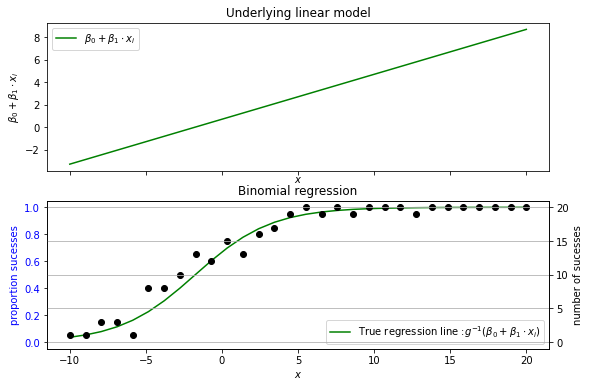

In [36]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x_binomial, μ_true,c='green', label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
freq.set_ylabel("number of sucesses")
freq.scatter(x_binomial, y_binomial, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x_binomial, p_true,c='green', label=r"True regression line :$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion sucesses", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

In [547]:
coords = {"observation": data.index.values}

with pm.Model() as binomial_regression_model:
    x_obs = pm.Data("x", data_binomial["x"])
    y_obs = pm.Data("y", data_binomial["y"])
    n_obs = pm.Data("n", 20)
    #x = pm.Data("x", data_binomial["x"])
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=1)
    # linear model
    μ = β0 + β1 * x_obs
    p = pm.Deterministic("p", pm.math.invlogit(μ))
    # likelihood
    pm.Binomial("obs", n=n, p=p, observed=y_obs)

In [548]:
with binomial_regression_model:
    trace_binomial_regression_model = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


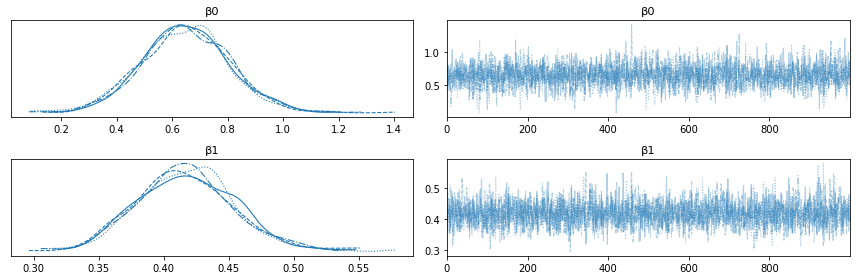

In [549]:
az.plot_trace(trace_binomial_regression_model, var_names=["β0", "β1"]);
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


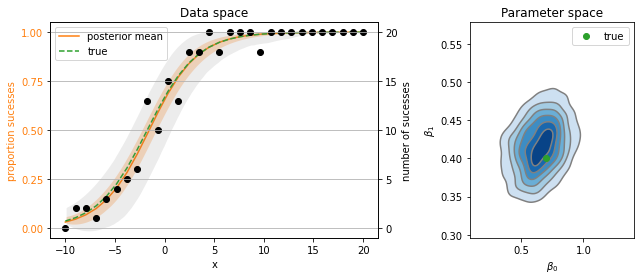

In [551]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data_binomial["x"],
    trace_binomial_regression_model.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

# posterior mean
post_mean = trace_binomial_regression_model.posterior.stack(sample=("chain", "draw")).p.mean("sample")
ax[0].plot(data_binomial["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data_binomial["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()

new_x=np.linspace(-10, 20, 1000)
with binomial_regression_model:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_binomial_regression_model,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=freq,
    color="grey",
)

freq.set_ylabel("number of sucesses")
freq.scatter(data_binomial["x"], data_binomial["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    trace_binomial_regression_model.posterior.stack(sample=("chain", "draw")).β0.values,
    trace_binomial_regression_model.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(β0_true, β1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

We could of course do it the frequentist way. If you use statsmodel like below, your target variable should be 2 dimensional : success and failure. Remember that the Binomial distribution needs $k$ and $n$ as entries to estimate $p$. Statsmodel get those info when fed both the number of success and failure.

In [34]:
data_binomial['success']=data_binomial['y']
data_binomial['failure']=n-data_binomial['y']
X_bin = data_binomial['x']
X_bin = sm.add_constant(X_bin)
y_bin = data_binomial[['success','failure']]
model_bin = sm.GLM(y_bin, X_bin,family=sm.families.Binomial())
results_bin = model_bin.fit()

print( results_bin.summary() )


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['success', 'failure']   No. Observations:                   30
Model:                                GLM   Df Residuals:                       28
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -33.999
Date:                    Mon, 28 Mar 2022   Deviance:                       19.088
Time:                            08:52:18   Pearson chi2:                     21.8
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       

## Real data

In this experiment, we would like to predict/understand the number of dead bees (ndied) in a population of bees of size nexp when exposed to a certain amount (dose) of pesticide.

Here the number of succeses is....ndied...

The number of tries is nexp

And the explanatory variable x is dose.

In [617]:
data_beetle=pd.read_csv('../Data-pymc/beetle.csv' , index_col=0)
data_beetle

dose  nexp  ndied   prop  nalive
1  49.1    59      6  0.102      53
2  53.0    60     13  0.217      47
3  56.9    62     18  0.290      44
4  60.8    56     28  0.500      28
5  64.8    63     52  0.825      11
6  68.7    59     53  0.898       6
7  72.6    62     61  0.984       1
8  76.5    60     60  1.000       0

Text(0, 0.5, 'Proportion of dead')

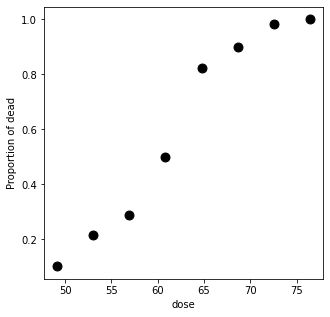

In [618]:
fig, ax = plt.subplots(ncols=1,figsize=(5,5))
ax.scatter( data_beetle["dose"], data_beetle["prop"],s=80,c='k')
ax.set_xlabel('dose')
ax.set_ylabel('Proportion of dead')

In [619]:


with pm.Model() as beetles_model:
    
    x_obs = pm.Data("x", data_beetle["dose"])
    y_obs = pm.Data("y", data_beetle["ndied"])
    n_obs = pm.Data("n", data_beetle["nexp"])
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=3)
    β1 = pm.Normal("β1", mu=0, sigma=1)
    # linear model
    μ = β0 + β1 * x_obs
    p = pm.Deterministic("p", pm.math.invlogit(μ))
    # likelihood
    pm.Binomial("obs", n=n_obs, p=p, observed=y_obs)

In [620]:
with beetles_model:
    trace_beetles_model = pm.sample(4000, tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.6969896310997078, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


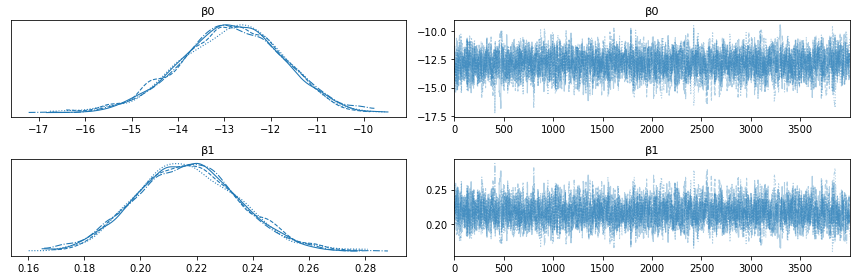

In [621]:
az.plot_trace(trace_beetles_model, var_names=["β0", "β1"]);
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


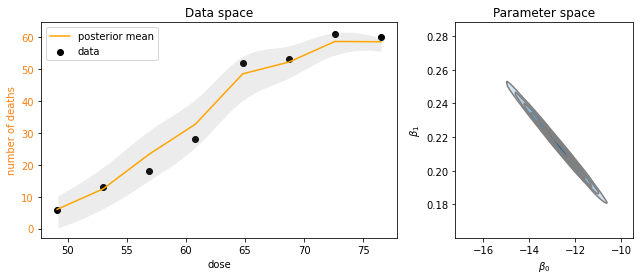

In [622]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================

# posterior mean
ax[0].scatter(data_beetle["dose"], data_beetle["ndied"], color="k", label="data")

# plot truth

# formatting
ax[0].set(xlabel="dose", title="Data space")
ax[0].set_ylabel("number of deaths", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")

ppc = pm.sample_posterior_predictive(trace_beetles_model,
                                     samples=4000,model = beetles_model)
ax[0].plot(data_beetle["dose"], np.mean(ppc['obs'],axis=0), "orange", label="posterior mean")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
#new_x=np.linspace(45, 85, 1000)
#n_new = np.random.randint(54,65,1000)
with beetles_model:
    pm.set_data({'x': data_beetle["dose"],'n':data_beetle["nexp"]})
    ppc = pm.sample_posterior_predictive(trace_beetles_model,
                                     samples=4000)

az.plot_hdi(
    data_beetle["dose"],
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

# Parameter space plot ===================================================
az.plot_kde(
    trace_beetles_model.posterior.stack(sample=("chain", "draw")).β0.values,
    trace_beetles_model.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)

ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")

plt.tight_layout()
plt.show()

## Poisson

The Poisson distribution describe the probability that a given number of success happens within a fixed interval of time or space.

There is a real obvious link to the Binomial distribution with the main difference being that the Binomial distribution counts the numbre of successes over a discrete numbre of tries, whereas Poisson counts it over a continuous interval (for example an interval of time which is thus continuous).

For example imagine you draw a 1cm² on the floor and count the number of rain drop falling within that square : this is a Poisson experiment. An example that we are going to study in a few cells is the case where you count the number of infections over some time windows.

The Poisson distribution has the folowing form :

$$\mathcal{P}(k,\lambda)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

In that case $\lambda$ is both the average number of successes and its variance.

So it is $\lambda$ that we should described as $g^{-1}(\pmb{\beta}^{T}\pmb{X})$

In this case $g^{-1}=exp()$

Going through the Covid infection example this log/exp scaling will probably make more sense.

In [48]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# true params
β0_true = -2.7
β1_true = 0.1



#sample_size = 50
x_poisson = np.arange(0, 50, 0.5)
# Linear model
lambda_true = β0_true + β1_true * x_poisson

p_true = np.exp(lambda_true)
# Generate data
y_poisson = rng.poisson(p_true)
# bundle data into dataframe
data_poisson = pd.DataFrame({"x": x_poisson, "y": y_poisson})

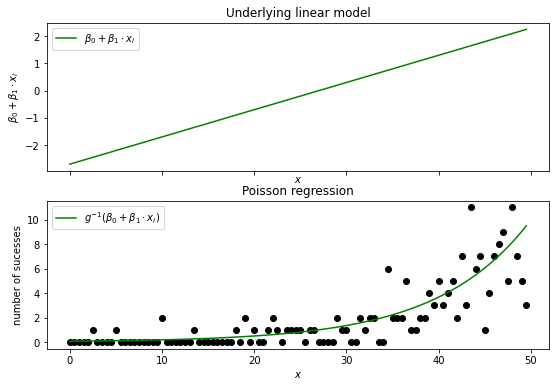

In [50]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x_poisson, lambda_true,'green', label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
  # instantiate a second axes that shares the same x-axis
ax[1].set_ylabel("number of sucesses")
ax[1].scatter(x_poisson, y_poisson, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x_poisson, p_true,'green', label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")


ax[1].set(xlabel="$x$", title="Poisson regression")
ax[1].legend()
# get y-axes to line up




In [51]:


with pm.Model() as poisson_regression_model:
    x_obs = pm.Data("x", data_poisson["x"])
    # priors
    β0 = pm.Normal("β0", mu=-1, sigma=3)
    β1 = pm.Normal("β1", mu=0, sigma=3)
    # linear model
    
    mu_poisson = pm.Deterministic("mu_poisson", np.exp(β0 + β1 * x_obs))
    # likelihood
    pm.Poisson("obs", mu=mu_poisson, observed=data_poisson["y"])

In [59]:
with poisson_regression_model:
    trace_poisson = pm.sample(4000, tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8826944635780911, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


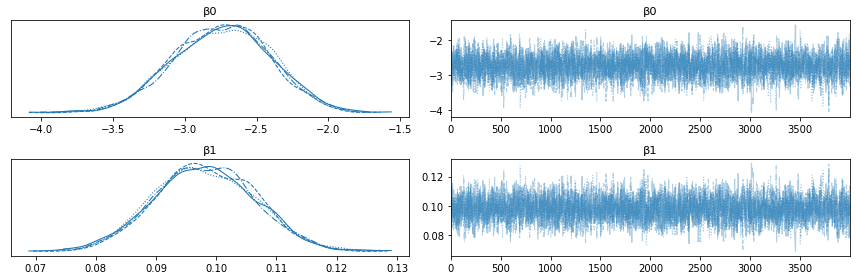

In [60]:
az.plot_trace(trace_poisson, var_names=["β0", "β1"]);
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


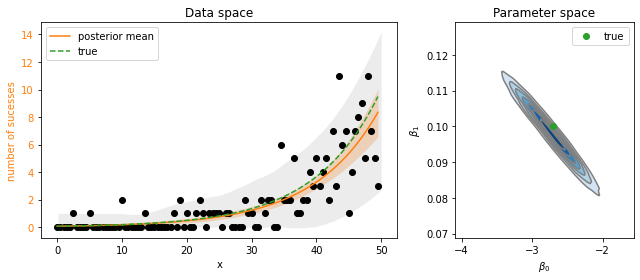

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data_poisson["x"],
    trace_poisson.posterior.mu_poisson,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
new_x=np.linspace(0, 50, 1000)
with poisson_regression_model:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_poisson,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

# posterior mean
post_mean = trace_poisson.posterior.stack(sample=("chain", "draw")).mu_poisson.mean("sample")
ax[0].plot(data_poisson["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data_poisson["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis

ax[0].set_ylabel("number of sucesses")
ax[0].scatter(data_poisson["x"], data_poisson["y"], color="k", label="data")
# get y-axes to line up


# Parameter space plot ===================================================
az.plot_kde(
    trace_poisson.posterior.stack(sample=("chain", "draw")).β0.values,
    trace_poisson.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(β0_true, β1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);
plt.tight_layout()
plt.show()

## Real data

Let's try to model the evolution of the number of Covid cases over 50 days or so.

Here the number of success is covid cases....

In [99]:
df_corona_exp=pd.read_csv('../Data-pymc/exponential_covid.csv')
df_corona_exp["Days"]=df_corona_exp.index*1.0
df_corona_exp.drop("Time",1,inplace=True)
df_corona_exp.head()

<ipython-input-99-3a8517e9c852>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_corona_exp.drop("Time",1,inplace=True)


Infections  Days
0           1   0.0
1           1   1.0
2           2   2.0
3           2   3.0
4           5   4.0

So here looking at the data, and with a little bit of domain knowledge we are looking at model of the kind $$n(t)=n(0)e^{\beta t}$$ where $\beta$ is the growth rate.

In that case we end up with the following linear relationship:
$$n(t)=n(0)e^{\beta t} \rightarrow$$
$$log(n(t)) = log( n(0)e^{\beta t} ) = log(n(0))+\beta t$$

Lookning at that last equation and realizing that $\bar{n(t)}=\lambda$ (because is it the average number of cases within a fixed interval t), we see that $\log(\lambda)= \pmb{\beta}^{T}\pmb{X}$, where X the explanatory variables are $\log(n(0))$ and $t$.

If we can write the $g=log$ of $\lambda$ as being linearly dependant on X, then $g^{-1}=exp()$

In [100]:


with pm.Model() as covid_poisson_model:
    x_obs = pm.Data("x", df_corona_exp["Days"])
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=3)
    β1 = pm.Normal("β1", mu=0, sigma=3)
    # linear model
    
    mu_poisson = pm.Deterministic("mu_poisson", np.exp(β0 + β1 * x_obs))
    # likelihood
    pm.Poisson("obs", mu=mu_poisson, observed=df_corona_exp["Infections"])

In [104]:
with covid_poisson_model:
    trace_covid_poisson_model = pm.sample(4000, tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.902628086470625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891501801971238, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


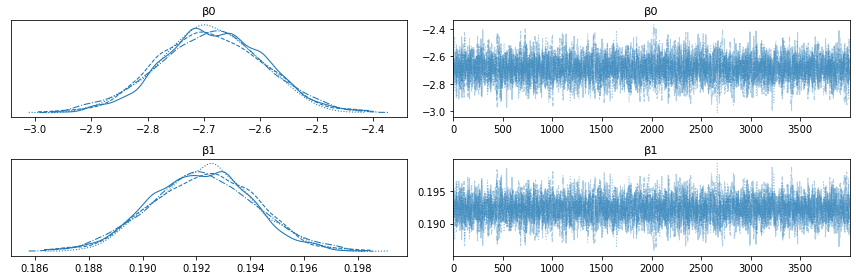

In [105]:
az.plot_trace(trace_covid_poisson_model, var_names=["β0", "β1"]);
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


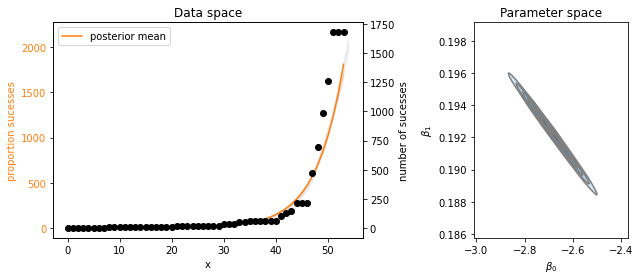

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    df_corona_exp['Days'],
    trace_covid_poisson_model.posterior.mu_poisson,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)

new_x=np.linspace(0, 54, 1000)#df_corona_exp['Days']
with covid_poisson_model:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_covid_poisson_model,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

# posterior mean
post_mean = trace_covid_poisson_model.posterior.stack(sample=("chain", "draw")).mu_poisson.mean("sample")
ax[0].plot(df_corona_exp['Days'], post_mean, label="posterior mean", color="C1")

# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of sucesses")
freq.scatter(df_corona_exp['Days'], df_corona_exp['Infections'], color="k", label="data")
# get y-axes to line up


# Parameter space plot ===================================================
az.plot_kde(
    trace_covid_poisson_model.posterior.stack(sample=("chain", "draw")).β0.values,
    trace_covid_poisson_model.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)

ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")

plt.tight_layout()
plt.show()

In [107]:
with pm.Model() as covid_NB_model:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    x_obs = pm.Data("x", df_corona_exp["Days"])
    # priors
    β0 = pm.Normal("β0", mu=0, sigma=3)
    β1 = pm.Normal("β1", mu=0, sigma=3)
    # linear model
    
    mu_NB = pm.Deterministic("mu_NB", np.exp(β0 + β1 * x_obs))
    # likelihood
    pm.NegativeBinomial("obs",alpha = sigma, mu=mu_NB, observed=df_corona_exp["Infections"])

In [108]:
with covid_NB_model:
    trace_covid_NB_model = pm.sample(4000, tune=4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0, sigma]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8854345338888988, but should be close to 0.8. Try to increase the number of tuning steps.


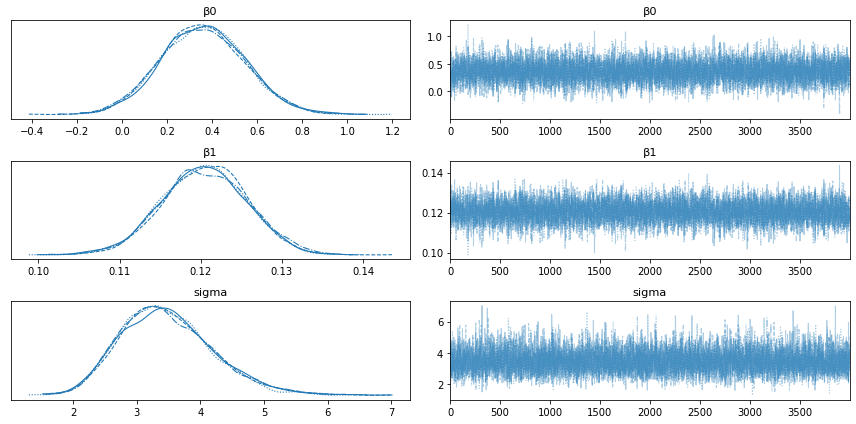

In [109]:
az.plot_trace(trace_covid_NB_model, var_names=["β0", "β1",'sigma']);
plt.tight_layout()
plt.show()

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


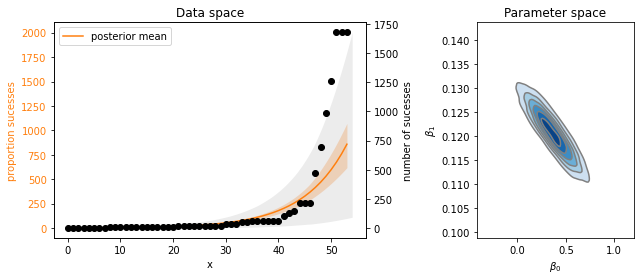

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    df_corona_exp['Days'],
    trace_covid_NB_model.posterior.mu_NB,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)


new_x=np.linspace(0, 54, 1000)#df_corona_exp['Days']
with covid_NB_model:
    pm.set_data({'x': new_x})
    ppc = pm.sample_posterior_predictive(trace_covid_NB_model,
                                     samples=4000)

az.plot_hdi(
    new_x,
    ppc["obs"],
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.15, "linewidth": 0},
    ax=ax[0],
    color="grey",
)

# posterior mean
post_mean = trace_covid_NB_model.posterior.stack(sample=("chain", "draw")).mu_NB.mean("sample")
ax[0].plot(df_corona_exp['Days'], post_mean, label="posterior mean", color="C1")

# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion sucesses", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of sucesses")
freq.scatter(df_corona_exp['Days'], df_corona_exp['Infections'], color="k", label="data")
# get y-axes to line up


# Parameter space plot ===================================================
az.plot_kde(
    trace_covid_NB_model.posterior.stack(sample=("chain", "draw")).β0.values,
    trace_covid_NB_model.posterior.stack(sample=("chain", "draw")).β1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)

ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")

plt.tight_layout()
plt.show()

# Unpooled, hierarchicaly pooled and pooled models

Radon is a radioactive noble gaz which depsite of its quite short half life time (short half life means high activity and dangerosity but also usually short term problem) represents a public safety concern as it is continuously produce by natural nuclear reaction of Uranium and Radium which are present more or less in abundance in different soil over the planet. 

One question that one could ask is are you more at risk to radon poisonning if you have a basement, as this kind of radiocativity is soil based. More over not all soil contain the same amount of radioactive material and some regoin of the world might be more enclined to producing this kind of radioactivity.

Hence radon level (and thus its dangerosity) should be at least model by the distance to the soil (do you have a basement or not) but also by the geology of where you live (hence some geographical information as a proxy).

This is what pymc3 example writes about this dataset :

`Gelman et al.’s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Here we’ll investigate this differences and try to make predictions of radonlevels in different counties based on the county itself and the presence of a basement. In this example we’ll look at Minnesota, a state that contains 85 counties in which different measurements are taken, ranging from 2 to 116 measurements per county.`

Let's see how we can do that modeling.

In [37]:
data = pd.read_csv(pm.get_data("radon.csv"))

county_names = data.county.unique()
county_names = data.county.unique()
data.head()

Unnamed: 0   idnum state state2  stfips    zip  region  typebldg  floor  \
0           0  5081.0    MN     MN    27.0  55735     5.0       1.0    1.0   
1           1  5082.0    MN     MN    27.0  55748     5.0       1.0    0.0   
2           2  5083.0    MN     MN    27.0  55748     5.0       1.0    0.0   
3           3  5084.0    MN     MN    27.0  56469     5.0       1.0    0.0   
4           4  5085.0    MN     MN    27.0  55011     3.0       1.0    0.0   

   room  ... pcterr        adjwt  dupflag  zipflag  cntyfips  county     fips  \
0   3.0  ...    9.7  1146.499190      1.0      0.0       1.0  AITKIN  27001.0   
1   4.0  ...   14.5   471.366223      0.0      0.0       1.0  AITKIN  27001.0   
2   4.0  ...    9.6   433.316718      0.0      0.0       1.0  AITKIN  27001.0   
3   4.0  ...   24.3   461.623670      0.0      0.0       1.0  AITKIN  27001.0   
4   4.0  ...   13.8   433.316718      0.0      0.0       3.0   ANOKA  27003.0   

       Uppm  county_code  log_radon  
0  0.502054            0   0.832909  
1  0.502054            0   0.832909  
2  0.502054            0   1.098612  
3  0.502054            0   0.095310  
4  0.428565            1   1.163151  

[5 rows x 30 columns]

/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


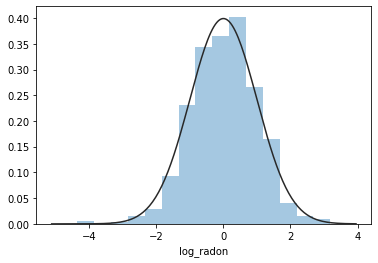

In [114]:
sns.distplot((data.log_radon-data.log_radon.mean())/data.log_radon.std(),15,fit=norm,norm_hist=True,kde=False)

plt.show()

In [115]:
c=stats.shapiro(data.log_radon)
print('W statistic is {0} and p-value is {1}'.format(c[0], c[1]))


W statistic is 0.9903322458267212 and p-value is 9.699280781205744e-06


/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/seb/anaconda3/envs/instadeep/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


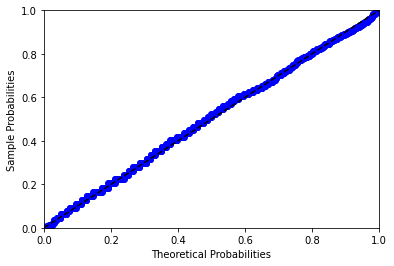

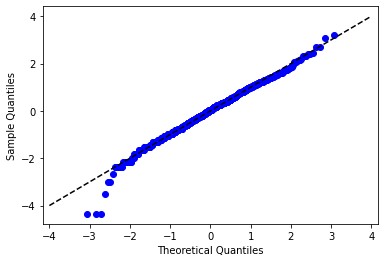

In [116]:
scaled_data=(data.log_radon-data.log_radon.mean())/data.log_radon.std()
pb=statsmodels.graphics.gofplots.ProbPlot(scaled_data)
pb.ppplot()
plt.plot([0,1],[0,1],'k--')
pb.qqplot()
plt.plot([-4,4],[-4,4],'k--')
plt.show()

Log of radon concentration is Normally distributed (vene though Shapiro is not convinced... but the QQ and PP plot speak for themselves).


The following is just a nice way to present the data to pymc3

In [71]:
county_idxs, counties = pd.factorize(data.county)
coords = {
    "county": counties,
    "obs_id": county_idxs,
}

In [72]:
dico_counties_ids={s:i for i,s in enumerate(counties)}

In [73]:
dico_counties_ids

{'AITKIN': 0,
 'ANOKA': 1,
 'BECKER': 2,
 'BELTRAMI': 3,
 'BENTON': 4,
 'BIG STONE': 5,
 'BLUE EARTH': 6,
 'BROWN': 7,
 'CARLTON': 8,
 'CARVER': 9,
 'CASS': 10,
 'CHIPPEWA': 11,
 'CHISAGO': 12,
 'CLAY': 13,
 'CLEARWATER': 14,
 'COOK': 15,
 'COTTONWOOD': 16,
 'CROW WING': 17,
 'DAKOTA': 18,
 'DODGE': 19,
 'DOUGLAS': 20,
 'FARIBAULT': 21,
 'FILLMORE': 22,
 'FREEBORN': 23,
 'GOODHUE': 24,
 'HENNEPIN': 25,
 'HOUSTON': 26,
 'HUBBARD': 27,
 'ISANTI': 28,
 'ITASCA': 29,
 'JACKSON': 30,
 'KANABEC': 31,
 'KANDIYOHI': 32,
 'KITTSON': 33,
 'KOOCHICHING': 34,
 'LAC QUI PARLE': 35,
 'LAKE': 36,
 'LAKE OF THE WOODS': 37,
 'LE SUEUR': 38,
 'LINCOLN': 39,
 'LYON': 40,
 'MAHNOMEN': 41,
 'MARSHALL': 42,
 'MARTIN': 43,
 'MCLEOD': 44,
 'MEEKER': 45,
 'MILLE LACS': 46,
 'MORRISON': 47,
 'MOWER': 48,
 'MURRAY': 49,
 'NICOLLET': 50,
 'NOBLES': 51,
 'NORMAN': 52,
 'OLMSTED': 53,
 'OTTER TAIL': 54,
 'PENNINGTON': 55,
 'PINE': 56,
 'PIPESTONE': 57,
 'POLK': 58,
 'POPE': 59,
 'RAMSEY': 60,
 'REDWOOD': 61,
 'RENV

Counties is just a list of counties

In [132]:
counties

Index(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
       'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
       'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
       'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
       'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
       'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
       'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADENA',
       'WASECA', 'WASHINGTON', 'WATONWAN', 'WILKIN'

In [136]:
list(data.county[60:80])

['BELTRAMI',
 'BELTRAMI',
 'BELTRAMI',
 'BELTRAMI',
 'BELTRAMI',
 'BELTRAMI',
 'BENTON',
 'BENTON',
 'BENTON',
 'BENTON',
 'BIG STONE',
 'BIG STONE',
 'BIG STONE',
 'BLUE EARTH',
 'BLUE EARTH',
 'BLUE EARTH',
 'BLUE EARTH',
 'BLUE EARTH',
 'BLUE EARTH',
 'BLUE EARTH']

county_idxs just change the name in numbers which is something the computeur understand better

In [137]:
county_idxs[60:80]

array([3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6])

## Unpooled model (same color code as before)

In this model we are going to fit separetly the relation between basement and log radon, for different counties. This is probably the most sane thing to do if we do actually believe that soil radon level are dependant on the county... But this is only a good way to do it if we had a good number of data points for every counties. This is not the case. Some counties have very few measure for the floor case, some have none (example Cass county). So we are loosing modelling power here. But this can still be a modelling option : at the end we will only trust the models for the counties for which we have enough points and kind of ignore or at least put less importance on the others.

In [65]:
data_grouped=data.groupby(by=['county'])

In [74]:
data_grouped_sum = data_grouped.sum()

data_grouped_sum['county_idx']=[dico_counties_ids[s] for s in data_grouped_sum.index]

In [75]:
data_grouped_sum

Unnamed: 0     idnum  stfips      zip  region  typebldg  \
county                                                                     
AITKIN                    6   20330.0   108.0   223700    20.0       4.0   
ANOKA                  1534  265746.0  1404.0  2872681   156.0      51.0   
BECKER                  171   15414.0    81.0   169546     6.0       3.0   
BELTRAMI                434   36001.0   189.0   396536    14.0       7.0   
BENTON                  270   20594.0   108.0   225466    20.0       4.0   
...                     ...       ...     ...      ...     ...       ...   
WATONWAN               2664   17907.0    81.0   168270    15.0       3.0   
WILKIN                  890    5971.0    27.0    56520     2.0       1.0   
WINONA                11661   77714.0   351.0   727642    52.0      14.0   
WRIGHT                11830   77883.0   351.0   719468    65.0      13.0   
YELLOW MEDICINE        1835   11997.0    54.0   112594    10.0       2.0   

                 floor   room  rep  stratum  ...  pcterr         adjwt  \
county                                       ...                         
AITKIN             1.0   15.0   12     10.0  ...    58.1   2512.805801   
ANOKA              3.0  154.0  147    137.0  ...   659.3  43156.757846   
BECKER             2.0    8.0   11      9.0  ...    37.8   3035.873498   
BELTRAMI           4.0   24.0   13     19.0  ...    42.7   6255.512995   
BENTON             1.0   13.0   15     13.0  ...    33.1   3982.891244   
...                ...    ...  ...      ...  ...     ...           ...   
WATONWAN           2.0   11.0    7     12.0  ...    12.1   3518.831219   
WILKIN             0.0    4.0    3      3.0  ...     4.2   1071.318034   
WINONA             3.0   38.0   31     39.0  ...    91.9  12823.599351   
WRIGHT             1.0   47.0   44     52.0  ...   104.2  15057.802759   
YELLOW MEDICINE    0.0    8.0    7      8.0  ...    17.6   2392.300134   

                 dupflag  zipflag  cntyfips       fips       Uppm  \
county                                                              
AITKIN               1.0      0.0       4.0   108004.0   2.008216   
ANOKA                2.0      0.0     156.0  1404156.0  22.285380   
BECKER               0.0      0.0      15.0    81015.0   2.678223   
BELTRAMI             4.0      0.0      49.0   189049.0   3.867304   
BENTON               0.0      0.0      36.0   108036.0   3.467396   
...                  ...      ...       ...        ...        ...   
WATONWAN             0.0      0.0     495.0    81495.0   3.603300   
WILKIN               0.0      0.0     167.0    27167.0   1.266220   
WINONA               3.0      0.0    2197.0   353197.0  20.659210   
WRIGHT               0.0      0.0    2223.0   353223.0  11.880817   
YELLOW MEDICINE      0.0      0.0     346.0    54346.0   2.853180   

                 county_code  log_radon  county_idx  
county                                               
AITKIN                     0   2.859741           0  
ANOKA                     52  46.324125           1  
BECKER                     6   3.270025           2  
BELTRAMI                  21   8.353120           3  
BENTON                    16   5.128952           4  
...                      ...        ...         ...  
WATONWAN                 240   6.721891          80  
WILKIN                    81   2.240710          81  
WINONA                  1066  19.463943          82  
WRIGHT                  1079  20.974897          83  
YELLOW MEDICINE          168   2.433613          84  

[85 rows x 26 columns]

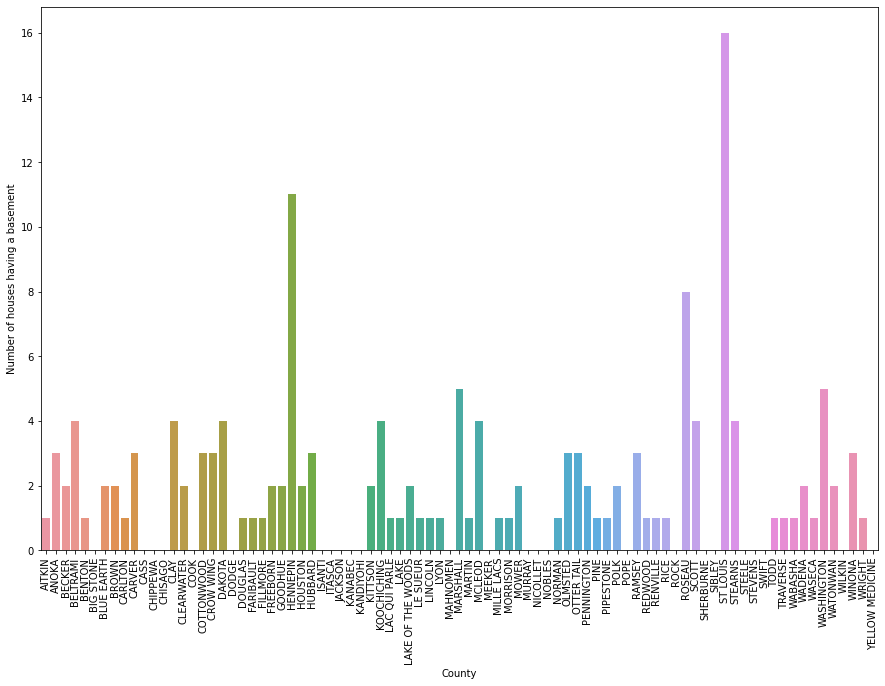

In [87]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
sns.barplot(x="county_idx", y='floor', data=data_grouped_sum)
plt.ylabel('Number of houses having a basement')
plt.xlabel('County')
plt.xticks(np.arange(len(dico_counties_ids)),list(dico_counties_ids.keys()),rotation=90)
plt.show()

So in this model a slope and and a bias will be etsimated for each of the counties independantly

In [88]:
with pm.Model(coords=coords) as unpooled_model:

    # Independent parameters for each county
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    floor = pm.Data("floor", data.floor.values, dims="obs_id")

    a = pm.Normal("a", 0, sigma=100, dims="county")
    b = pm.Normal("b", 0, sigma=100, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = pm.Deterministic('radon_est',a[county_idx] + b[county_idx] * floor)

    # Data likelihood
    y = pm.Normal("obs", mu=radon_est, sigma=eps, observed=data.log_radon, dims="obs_id")

Frome the following plots we can see that there is a big variation in the bias a, according to the county (see the different peaks that are all mostly positive) and a huge variability in the slope estimate for the counties. What I mean by that is that for a some counties, slopes estimates varies between something like $0\pm250$. This is the loss of statistical power I was talking about.

In [89]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


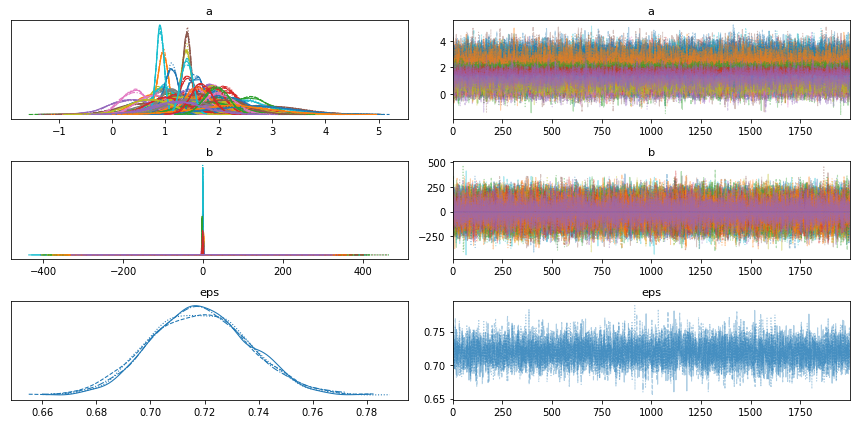

In [90]:
az.plot_trace(unpooled_trace, var_names=["a", "b", "eps"]);
plt.tight_layout()

In [91]:
def plotting_hierarchical_unpooled_model_prediction(model,trace,floor,county):
    county_ids = np.array([dico_counties_ids[county]]*floor.shape[0])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    with model:
        pm.set_data({'county_idx': county_ids,'floor':floor})
        ppc = pm.sample_posterior_predictive(trace,
                                         samples=4000,var_names=['obs','radon_est'])

        az.plot_hdi(
        floor,
        ppc["obs"],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.15, "linewidth": 0},
        ax=ax,
        color="grey",
        )
        
        az.plot_hdi(
        floor,
        ppc["radon_est"],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.15, "linewidth": 0},
        ax=ax,
        color="orange",
        )
        sub_data = data.loc[data['county'] == county, ['log_radon','floor']]
        
        ax.plot(sub_data['floor'],sub_data['log_radon'],'ko')
        ax.plot(floor,np.mean(ppc['obs'],axis=0),"orange")
        ax.set_ylabel('log radon')
        ax.set_title(county)
        ax.set_xticks([1,0])
        ax.set_xticklabels(['no basement','basement'])
        plt.show()

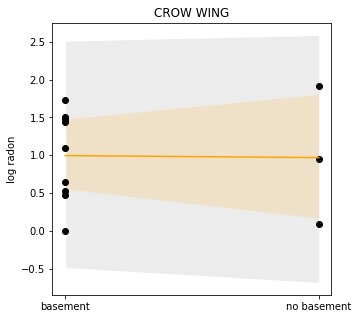

In [92]:
plotting_hierarchical_unpooled_model_prediction(unpooled_model,unpooled_trace,np.array([0.0,1.0]),'CROW WING')

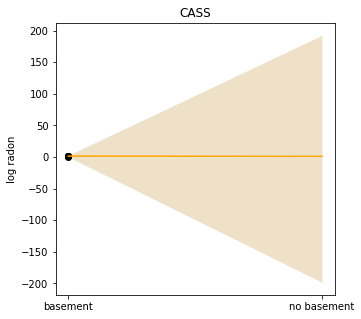

In [93]:
plotting_hierarchical_unpooled_model_prediction(unpooled_model,unpooled_trace,np.array([0.0,1.0]),'CASS')

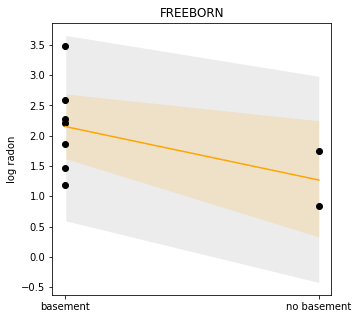

In [94]:
plotting_hierarchical_unpooled_model_prediction(unpooled_model,unpooled_trace,np.array([0.0,1.0]),'FREEBORN')

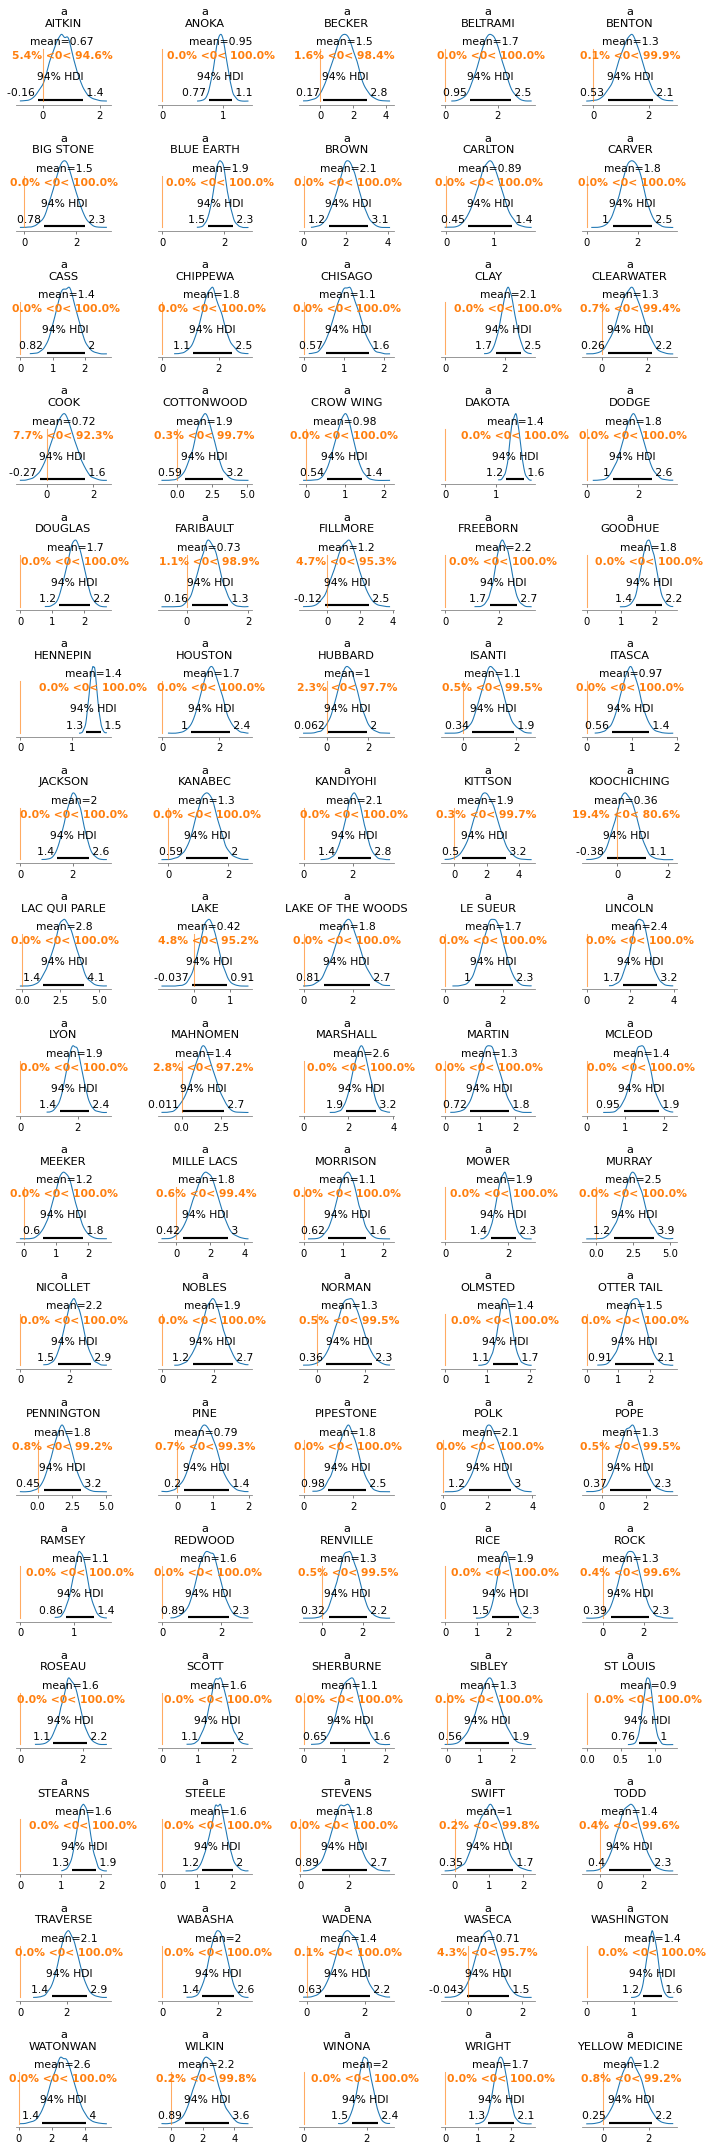

In [206]:
[fig, axes] = plt.subplots(17, 5, figsize=(10, 30))
az.plot_posterior(unpooled_trace, var_names=["a"], 
                  ref_val=0,ax=axes,textsize=10)
plt.tight_layout()
plt.show()

## Hierarchicaly pooled model

In this model we say the following :
    
County is an important factor in modelling the radon levels according to the presence of a basement or not, but it can not be so important than 2 county would behave absolutly differently. 

How do we encode that?

By just saying that the slopes and the bias are allowed to be county dependant but within a certain range of what is possible : all the slopes and bias can be different but should be linked together by the fact that they were produced by the same distribution.

Basicaly we can say that there exist a latent mean $\mu_a$ and a latent standard deviation $\sigma_a$ that would encode the fact that every bias could be different according to the county but within $\mu_a\pm \sigma_a$ . The same is true for the slope b.

This means that now we can pool all the data together (so exit the statistical power problem) to estimate  $\mu_a,\sigma_a$ and $\mu_b,\sigma_b$ and work then more specifically on subset of data to estimate a and b by county. But we already have pooled some valuable information thanks to the full dataset , so it is the best of both world in terms of modelling

In [95]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    floor = pm.Data("floor", data.floor.values, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="county")
    # effect difference between basement and floor level
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = pm.Deterministic('radon_est',a[county_idx] + b[county_idx] * floor)
    # Data likelihood
    radon_like = pm.Normal(
        "obs", mu=radon_est, sigma=eps, observed=data.log_radon, dims="obs_id"
    )


In [96]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=15000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 15_000 tune and 2_000 draw iterations (60_000 + 8_000 draws total) took 316 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Look at how now by pooling the information together in a rational way we have the same kind of estimates as before for the bias, but way more tighten estimatet for the slopes which are between -2 and 1 with most peaking around somethjing like -0.6. This a way better model in my opinion

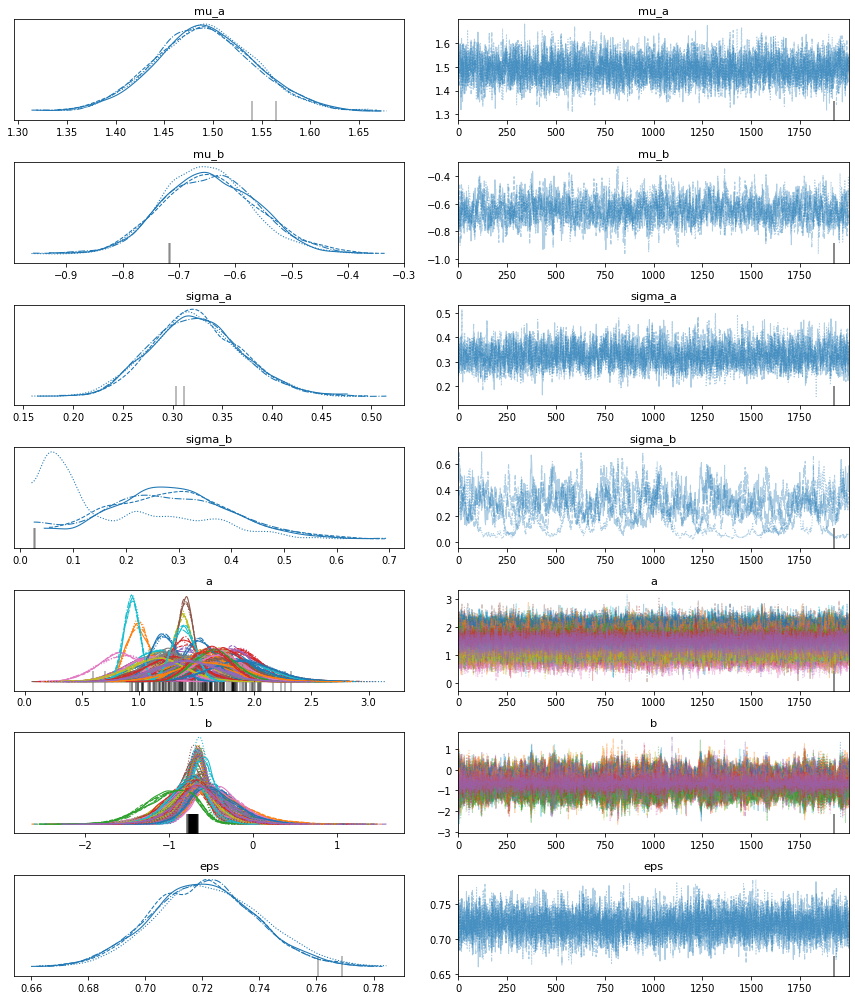

In [97]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b",'a','b', "eps"]);
plt.tight_layout()

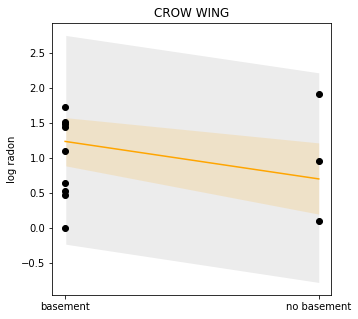

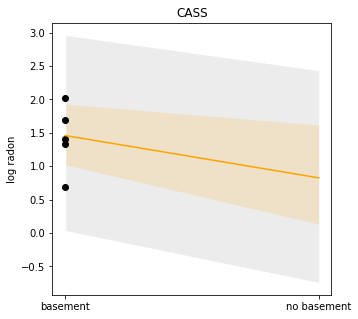

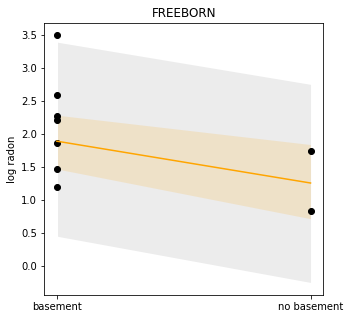

In [98]:
plotting_hierarchical_unpooled_model_prediction(hierarchical_model,hierarchical_trace,np.array([0.0,1.0]),'CROW WING')

plotting_hierarchical_unpooled_model_prediction(hierarchical_model,hierarchical_trace,np.array([0.0,1.0]),'CASS')

plotting_hierarchical_unpooled_model_prediction(hierarchical_model,hierarchical_trace,np.array([0.0,1.0]),'FREEBORN')



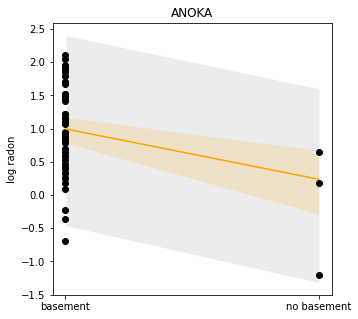

In [99]:
plotting_hierarchical_unpooled_model_prediction(hierarchical_model,hierarchical_trace,np.array([0.0,1.0]),'ANOKA')


In [100]:
az.rcParams["plot.max_subplots"] = 100 

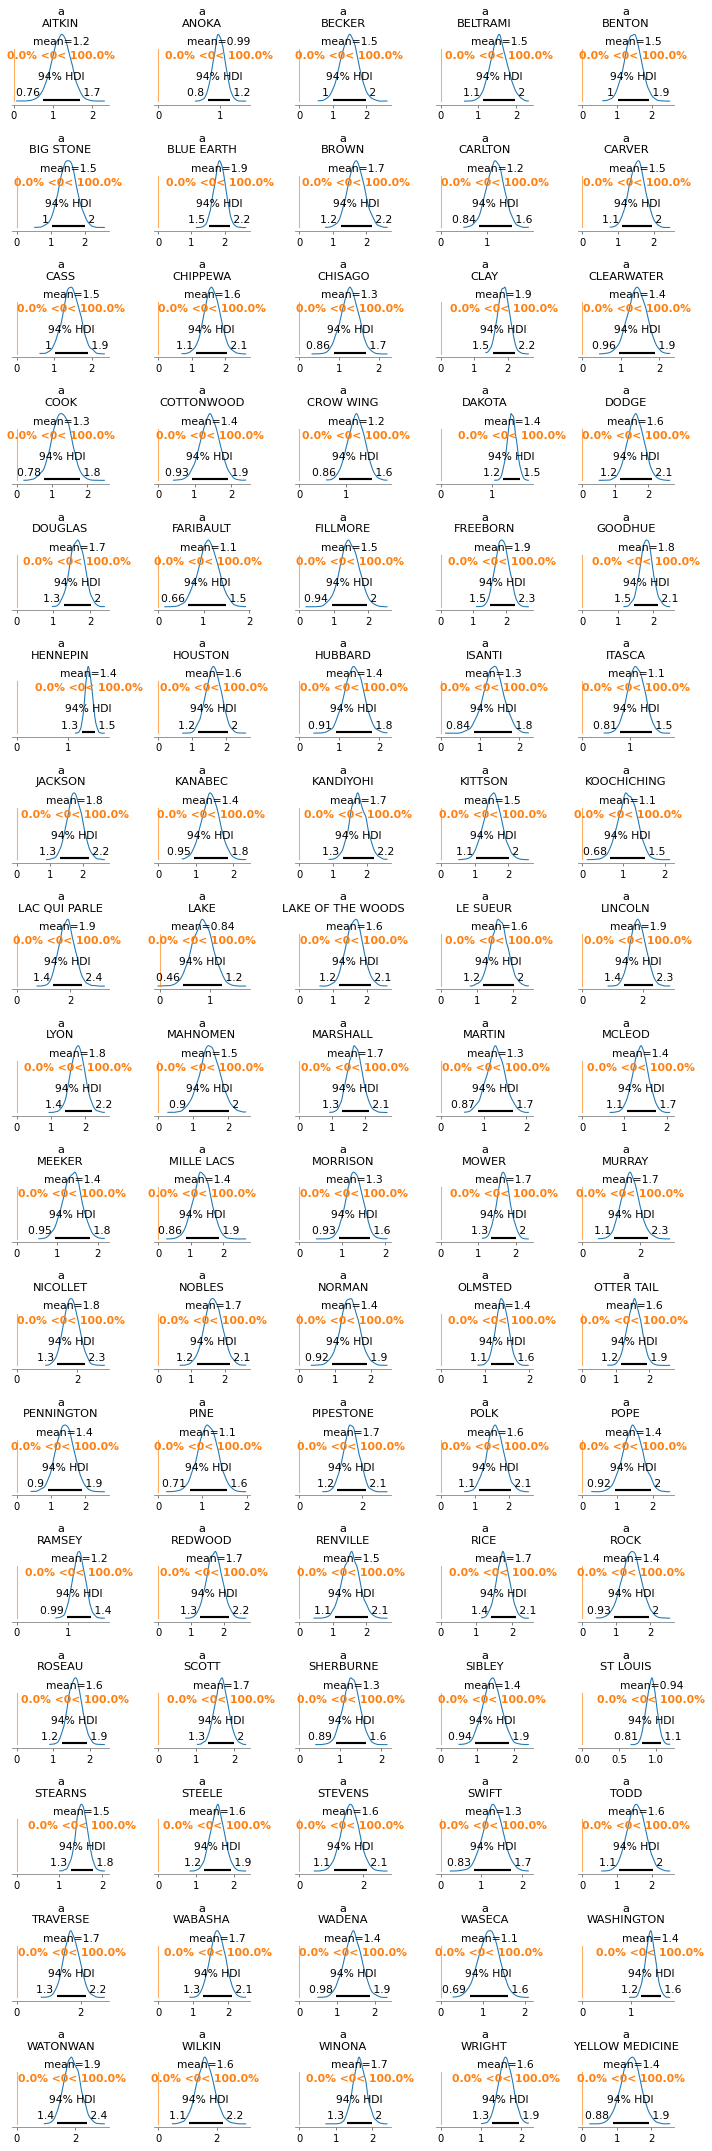

In [205]:
[fig, axes] = plt.subplots(17, 5, figsize=(10, 30))
az.plot_posterior(hierarchical_trace, var_names=["a"], 
                  ref_val=0,ax=axes,textsize=10)
plt.tight_layout()
plt.show()

## Pooled model

In this model we forget about the potential influence of the county and we pool all the data together in the hypothethis that this data was produced by a unique singular model described by only one slope and one bias.

In [101]:
with pm.Model(coords=coords) as pooled_model:
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    floor = pm.Data("floor", data.floor.values, dims="obs_id")

    # 
    
    a = pm.Normal("a", 0, sigma=100)
    b = pm.Normal("b", 0, sigma=100)

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a + b * floor
    radon_est = pm.Deterministic('radon_est',a+ b * floor)
    # Data likelihood
    y = pm.Normal("obs", radon_est, sigma=eps, observed=data.log_radon, dims="obs_id")

In [102]:
with pooled_model:
    pooled_trace = pm.sample(2000, tune=15000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 15_000 tune and 2_000 draw iterations (60_000 + 8_000 draws total) took 25 seconds.


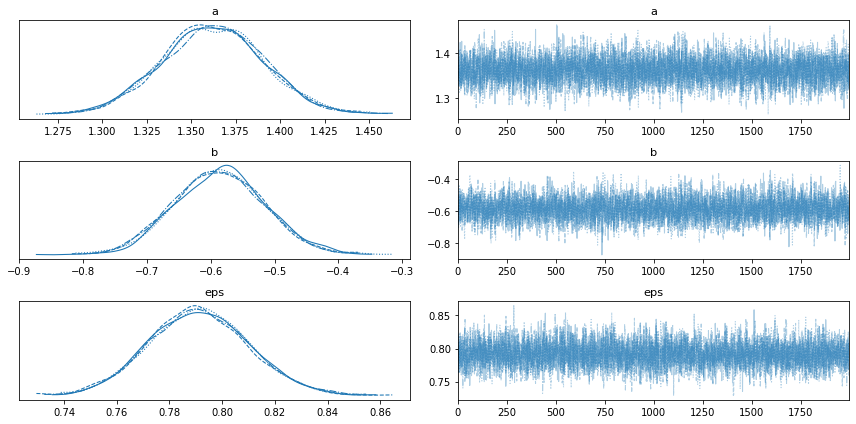

In [103]:
az.plot_trace(pooled_trace, var_names=["a", "b", "eps"]);
plt.tight_layout()

The problem with this model is that it doesn't take into account the specifity of the county and so gives a very general answer which is good in most of the case but also very wrong for some.

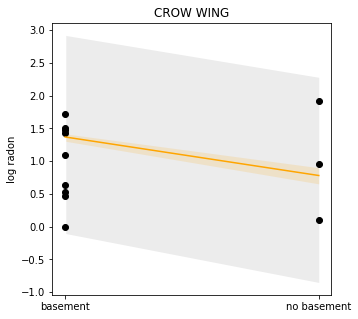

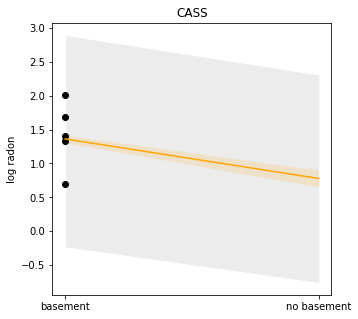

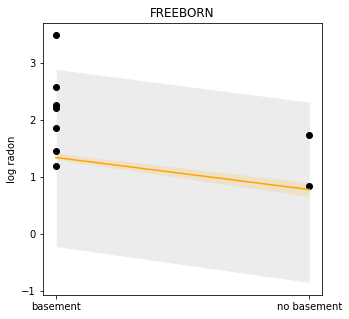

In [104]:
plotting_hierarchical_unpooled_model_prediction(pooled_model,pooled_trace,np.array([0.0,1.0]),'CROW WING')

plotting_hierarchical_unpooled_model_prediction(pooled_model,pooled_trace,np.array([0.0,1.0]),'CASS')

plotting_hierarchical_unpooled_model_prediction(pooled_model,pooled_trace,np.array([0.0,1.0]),'FREEBORN')



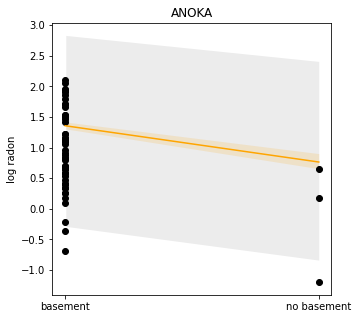

In [105]:
plotting_hierarchical_unpooled_model_prediction(pooled_model,pooled_trace,np.array([0.0,1.0]),'ANOKA')


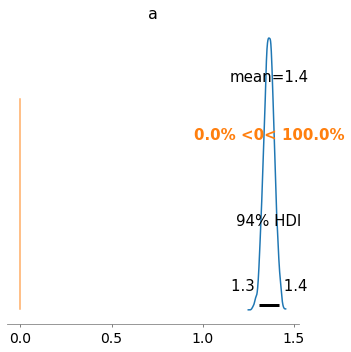

In [208]:
[fig, axes] = plt.subplots(1, 1, figsize=(5, 5))
az.plot_posterior(pooled_trace, var_names=["a"], 
                  ref_val=0,ax=axes)
plt.tight_layout()
plt.show()

# Mixture of models

## Gaussian mixture 

## Group Based Linear Modeling

# Gaussian processes and Kernel methods

# Models comparison

# MC Methods